In [135]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np

In [136]:
# silences pandas warnings
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 300)

### Functions

In [137]:
# Function to update Elo rating after a match
def update_elo(player1_elo, player2_elo, result, k_factor=32):
    expected_score_player1 = 1 / (1 + 10 ** ((player2_elo - player1_elo) / 400))
    expected_score_player2 = 1 - expected_score_player1

    player1_new_elo = player1_elo + k_factor * (result - expected_score_player1)
    player2_new_elo = player2_elo + k_factor * ((1 - result) - expected_score_player2)

    return player1_new_elo, player2_new_elo

# Function to regress Elo ratings towards the mean
def regress_to_mean(elo_ratings, mean_elo, regression_weight=1/3):
    elo_ratings['Elo'] = elo_ratings['Elo'] + regression_weight * (mean_elo - elo_ratings['Elo'])
    return elo_ratings 

# Function to calculate mean Elo
def calculate_mean_elo(elo_ratings):
    return elo_ratings.Elo.sum() / len(elo_ratings)

def get_elo(team,season,week,df):
    try:
        elo = [df.loc[(df['Team']==team)&(df['Season']==season)&(df['Week']==week-1)], 'Elo'].values[0]
    except:
        team_week = df.loc[(df['Team']==team)&(df['Season']==season)&(df['Week']<week)]['Week'].max()
        elo = df.loc[(df['Team']==team)&(df['Season']==season)&(df['Week']==team_week), 'Elo'].values[0]   
    return elo

def get_qb_elo(qb_id,season,week,historical_elo_qb):
    if week == 1:
        try:
            qb_week = historical_elo_qb.loc[(historical_elo_qb['passer_id']==qb_id)&(historical_elo_qb['Season']==season-1)]['Week'].max()
            elo = historical_elo_qb.loc[(historical_elo_qb['passer_id']==qb_id)&(historical_elo_qb['Season']==season-1)&(historical_elo_qb['Week']==qb_week), 'Elo'].values[0]
        except:
            try:
                qb_season = historical_elo_qb.loc[(historical_elo_qb['passer_id']==qb_id)&(historical_elo_qb['Season']<season)]['Season'].max()
                qb_week = historical_elo_qb.loc[(historical_elo_qb['passer_id']==qb_id)&(historical_elo_qb['Season']==qb_season)]['Week'].max()
                elo = historical_elo_qb.loc[(historical_elo_qb['passer_id']==qb_id)&(historical_elo_qb['Season']==qb_season)&(historical_elo_qb['Week']==qb_week), 'Elo'].values[0]
            except:
                elo = 1500
    else:
        try:
            elo = [historical_elo_qb.loc[(historical_elo_qb['passer_id']==qb_id)&(historical_elo_qb['Season']==season)&(historical_elo_qb['Week']==week-1)], 'Elo'].values[0]
        except:
            try:
                qb_week = historical_elo_qb.loc[(historical_elo_qb['passer_id']==qb_id)&(historical_elo_qb['Season']==season)&(historical_elo_qb['Week']<week)]['Week'].max()
                elo = historical_elo_qb.loc[(historical_elo_qb['passer_id']==row['home_qb_id'])&(historical_elo_qb['Season']==season)&(historical_elo_qb['Week']==qb_week), 'Elo'].values[0]
            except:
                try:
                    qb_season = historical_elo_qb.loc[(historical_elo_qb['passer_id']==qb_id)&(historical_elo_qb['Season']<season)]['Season'].max()
                    qb_week = historical_elo_qb.loc[(historical_elo_qb['passer_id']==qb_id)&(historical_elo_qb['Season']==qb_season)]['Week'].max()
                    elo = historical_elo_qb.loc[(historical_elo_qb['passer_id']==row['home_qb_id'])&(historical_elo_qb['Season']==qb_season)&(historical_elo_qb['Week']==qb_week), 'Elo'].values[0]
                except:
                    elo = 1500
    
    return elo

def get_value(df, season, week, team, team_col_name, num, denom):
    '''Get weighted average of stats over the last two seasons'''
    df_temp = df.loc[(df['season']==season)&(df['week']<week)&(df[team_col_name]==team)]
    value = df_temp[num].sum()/df_temp[denom].sum()
    df_temp2 = df.loc[(df['season']==season-1)&(df[team_col_name]==team)]
    value2 = df_temp2[num].sum()/df_temp2[denom].sum()
    if week == 1:
        final_value = value2
    elif week > 12:
        final_value = value
    else:
        final_value = week*value/12 + (12-week)*value2/17
    
    return final_value

def get_qbr(df, season, week, qb_id):
    '''Get weighted average of QBR over the last two seasons'''
    try:
        df_temp = df.loc[(df['season']==season)&(df['game_week']<week)&(df['gsis_id']==qb_id)]
        df_temp['weighted'] = df_temp['qbr_total']*df_temp['qb_plays']/df_temp['qb_plays'].sum()
        value = df_temp['weighted'].sum()
    except:
        value = 50.0
    try:
        df_temp2 = df.loc[(df['season']==season-1)&(df['gsis_id']==qb_id)]
        df_temp2['weighted'] = df_temp2['qbr_total']*df_temp2['qb_plays']/df_temp2['qb_plays'].sum()
        value2 = df_temp2['weighted'].sum()
    except:
        value2 = 50.0
    if week == 1:
        final_value = value2
    elif week > 12:
        final_value = value
    else:
        final_value = week*value/12 + (12-week)*value2/17
    
    return final_value

### Data Extraction

In [138]:
years = [year for year in range(1999, 2023)]

In [139]:
weekly_data = nfl.import_weekly_data(years)

Downcasting floats.


In [140]:
matchups = nfl.import_schedules(years)

In [141]:
matchups.tail()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
6416,2022_20_CIN_BUF,2022,DIV,20,2023-01-22,Sunday,15:00,CIN,27.0,BUF,10.0,Home,-17.0,37.0,0.0,2023012200,NaN,NaN,202301220buf,NaN,401438007.0,6159.0,7,7,226.0,-259.0,6.0,-107.0,-103.0,48.5,-107.0,-105.0,0,outdoors,a_turf,32.0,4.0,00-0036442,00-0034857,Joe Burrow,Josh Allen,Zac Taylor,Sean McDermott,Carl Cheffers,BUF00,New Era Field
6417,2022_20_DAL_SF,2022,DIV,20,2023-01-22,Sunday,18:30,DAL,12.0,SF,19.0,Home,7.0,31.0,0.0,2023012201,NaN,NaN,202301220sfo,NaN,401438006.0,6160.0,6,8,164.0,-183.0,3.5,-107.0,-103.0,46.5,-105.0,-107.0,0,outdoors,grass,55.0,19.0,00-0033077,00-0037834,Dak Prescott,Brock Purdy,Mike McCarthy,Kyle Shanahan,Bill Vinovich,SFO01,Levi's Stadium
6418,2022_21_SF_PHI,2022,CON,21,2023-01-29,Sunday,15:00,SF,7.0,PHI,31.0,Home,24.0,38.0,0.0,2023012900,NaN,NaN,202301290phi,NaN,401438009.0,6161.0,7,8,133.0,-147.0,2.5,105.0,-116.0,45.0,-114.0,101.0,0,outdoors,grass,52.0,14.0,00-0037834,00-0036389,Brock Purdy,Jalen Hurts,Kyle Shanahan,Nick Sirianni,John Hussey,PHI00,Lincoln Financial Field
6419,2022_21_CIN_KC,2022,CON,21,2023-01-29,Sunday,18:30,CIN,20.0,KC,23.0,Home,3.0,43.0,0.0,2023012901,NaN,NaN,202301290kan,NaN,401438008.0,6162.0,7,8,119.0,-131.0,2.0,-103.0,-107.0,48.5,-106.0,-106.0,0,outdoors,grass,22.0,13.0,00-0036442,00-0033873,Joe Burrow,Patrick Mahomes,Zac Taylor,Andy Reid,Ron Torbert,KAN00,GEHA Field at Arrowhead Stadium
6420,2022_22_KC_PHI,2022,SB,22,2023-02-12,Sunday,18:30,KC,38.0,PHI,35.0,Neutral,-3.0,73.0,0.0,2023021200,NaN,NaN,202302120phi,NaN,401438030.0,6163.0,14,14,104.0,-115.0,1.0,-103.0,-107.0,51.0,-104.0,-108.0,0,closed,grass,NaN,NaN,00-0033873,00-0036389,Patrick Mahomes,Jalen Hurts,Andy Reid,Nick Sirianni,Carl Cheffers,PHO00,State Farm Stadium


In [142]:
upcoming = nfl.import_schedules([2023])

In [143]:
qbr = nfl.import_qbr([year for year in range(2007, 2023)], level='nfl', frequency='weekly')

In [145]:
data = nfl.import_pbp_data([year for year in range(1999, 2023)])

1999 done.
2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


### Feature Engineering

In [146]:
# Dictionary of all relocated teams
replace_dict = {'OAK':'LV','STL':'LA','SD':'LAC'}

In [147]:
# Replace any relocated teams
data['home_team'] = data['home_team'].replace(replace_dict)
data['away_team'] = data['away_team'].replace(replace_dict)

In [148]:
data.head()

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,td_player_name,td_player_id,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,vegas_wpa,vegas_home_wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,...,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_id,assist_tackle_4_player_name,assist_tackle_4_team,tackle_with_assist,tackle_with_assist_1_player_id,tackle_with_assist_1_player_name,tackle_with_assist_1_team,tackle_with_assist_2_player_id,tackle_with_assist_2_player_name,tackle_with_assist_2_team,pass_defense_1_player_id,pass_defense_1_player_name,pass_defense_2_player_id,pass_defense_2_player_name,fumbled_1_team,fumbled_1_player_id,fumbled_1_player_name,fumbled_2_player_id,fumbled_2_player_name,fumbled_2_team,fumble_recovery_1_team,fumble_recovery_1_yards,fumble_recovery_1_player_id,fumble_recovery_1_player_name,fumble_recovery_2_team,fumble_recovery_2_yards,fumble_recovery_2_player_id,fumble_recovery_2_player_name,sack_player_id,sack_player_name,half_sack_1_player_id,half_sack_1_player_name,half_sack_2_player_id,half_sack_2_player_name,return_team,return_yards,penalty_team,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,safety_player_name,safety_player_id,season,cp,cpoe,series,series_success,series_result,order_sequence,start_time,time_of_day,stadium,weather,nfl_api_id,play_clock,play_deleted,play_type_nfl,special_teams_play,st_play_type,end_clock_time,end_yard_line,fixed_drive,fixed_drive_result,drive_real_start_time,drive_play_count,drive_time_of_possession,drive_first_downs,drive_inside20,drive_ended_with_score,drive_quarter_start,drive_quarter_end,drive_yards_penalized,drive_start_transition,drive_end_transition,drive_game_clock_start,drive_game_clock_end,drive_start_yard_line,drive_end_yard_line,drive_play_id_started,drive_play_id_ended,away_s

In [150]:
# pass_att = data.loc[data['play_type']=='pass']
pass_att = data.loc[data['play_type_nfl']=='PASS']
rush_att = data.loc[data['play_type']=='rush']
plays = data.loc[data['play']==1.0]

In [151]:
pass_stats = pass_att.pivot_table(index=['passer_id','passer','season','season_type','week','game_id','game_date','posteam','defteam'], values=['play_id','incomplete_pass','yards_gained','interception', \
    'pass_touchdown'], aggfunc={'play_id':'count', 'incomplete_pass': 'sum','yards_gained': 'sum','interception': 'sum','pass_touchdown': 'sum',}).reset_index().sort_values(by='play_id', \
        ascending=False)

In [152]:
# Create passer rating
pass_stats.loc[:,'completion_pct'] = 1-(pass_stats.loc[:,'incomplete_pass']+pass_stats.loc[:,'interception'])/pass_stats.loc[:,'play_id']
pass_stats.loc[:,'yards_per_att'] = pass_stats.loc[:,'yards_gained']/pass_stats.loc[:,'play_id']
pass_stats.loc[:,'td_per_att'] = pass_stats.loc[:,'pass_touchdown']/pass_stats.loc[:,'play_id']
pass_stats.loc[:,'int_per_att'] = pass_stats.loc[:,'interception']/pass_stats.loc[:,'play_id']
pass_stats.loc[:,'a'] = np.where((5*(pass_stats.loc[:,'completion_pct']-0.3)<=2.375)&(5*(pass_stats.loc[:,'completion_pct']-0.3)>=0), 5*(pass_stats.loc[:,'completion_pct']-0.3), \
    np.where((5*(pass_stats.loc[:,'completion_pct']-0.3)>2.375), 2.375, 0))
pass_stats.loc[:,'b'] = np.where(((0.25*(pass_stats.loc[:,'yards_per_att']-3))<=2.375)&((0.25*(pass_stats.loc[:,'yards_per_att']-3))>=0), (0.25*(pass_stats.loc[:,'yards_per_att']-3)), \
    np.where(((0.25*(pass_stats.loc[:,'yards_per_att']-3))>2.375), 2.375, 0))
pass_stats.loc[:,'c'] = np.where(((20*pass_stats.loc[:,'td_per_att'])<=2.375)&((20*pass_stats.loc[:,'td_per_att'])>=0), (20*pass_stats.loc[:,'td_per_att']), \
    np.where(((20*pass_stats.loc[:,'td_per_att'])>2.375), 2.375, 0))
pass_stats.loc[:,'d'] = np.where(((2.375-(25*pass_stats.loc[:,'int_per_att']))<=2.375)&((2.375-(25*pass_stats.loc[:,'int_per_att']))>=0), (2.375-(25*pass_stats.loc[:,'int_per_att'])), \
    np.where(((2.375-(25*pass_stats.loc[:,'int_per_att']))>2.375), 2.375, 0))
pass_stats.loc[:,'passer_rating'] = 100*((pass_stats.loc[:,'a']+pass_stats.loc[:,'b']+pass_stats.loc[:,'c']+pass_stats.loc[:,'d'])/6)

In [153]:
# At least 10 pass attempts
pass_stats = pass_stats.loc[pass_stats['play_id']>=10]

In [154]:
pass_stats = pass_stats.sort_values(by='game_date').reset_index()

In [155]:
# To check for season change
pass_stats['season_shift'] = pass_stats['season'].shift().fillna(0.0)

In [156]:
# Initial elo rating
initial_elo = 1500

# Create a dictionary to hold current Elo ratings for each player
qb_ratings = {player: initial_elo for player in pass_stats['passer_id'].unique()}
def_ratings = {team: initial_elo for team in pass_stats['defteam'].unique()}

# Create a separate DataFrame to store the updated Elo ratings
elo_qb = pd.DataFrame(qb_ratings.items(), columns=['passer_id', 'Elo'])
elo_qb = elo_qb.merge(pass_stats[['passer_id', 'passer']].drop_duplicates(), how='inner', on='passer_id')
elo_def = pd.DataFrame(def_ratings.items(), columns=['Team', 'Elo'])

In [157]:
pass_stats.head()

,index,passer_id,passer,season,season_type,week,game_id,game_date,posteam,defteam,incomplete_pass,interception,pass_touchdown,play_id,yards_gained,completion_pct,yards_per_att,td_per_att,int_per_att,a,b,c,d,passer_rating,season_shift
0,1305,00-0005885,J.George,2001,REG,1,2001_01_WAS_SD,2001-09-09,WAS,LAC,8.0,2.0,0.0,18,66.0,0.444444,3.666667,0.000000,0.111111,0.722222,0.166667,0.000000,0.000000,14.814815,0.0
1,1764,00-0008442,B.Johnson,2001,REG,1,2001_01_TB_DAL,2001-09-09,TB,DAL,8.0,1.0,0.0,34,195.0,0.735294,5.735294,0.000000,0.029412,2.176471,0.683824,0.000000,1.639706,75.000000,2001.0
2,2484,00-0011024,S.McNair,2001,REG,1,2001_01_MIA_TEN,2001-09-09,TEN,MIA,11.0,1.0,1.0,19,118.0,0.368421,6.210526,0.052632,0.052632,0.342105,0.802632,1.052632,1.059211,54.276316,2001.0
3,1857,00-0008612,R.Johnson,2001,REG,1,2001_01_NO_BUF,2001-09-09,BUF,NO,8.0,3.0,0.0,27,160.0,0.592593,5.925926,0.000000,0.111111,1.462963,0.731481,0.000000,0.000000,36.574074,2001.0
4,2830,00-0016193,V.Testaverde,2001,REG,1,2001_01_IND_NYJ,2001-09-09,NYJ,IND,8.0,0.0,2.0,25,175.0,0.680000,7.000000,0.080000,0.000000,1.900000,1.000000,1.600000,2.375000,114.583333,2001.0


In [158]:
# Create a new DataFrame to hold historical weekly Elo ratings for each team and QB
historical_elo_def = pd.DataFrame(columns=['Team', 'Season', 'Week', 'Elo'])
historical_elo_qb = pd.DataFrame(columns=['passer_id', 'Passer', 'Season', 'Week', 'Elo'])

# Iterate through matchups DataFrame and update Elo ratings
for index, row in pass_stats.iterrows():

    # Check if the season has ended (you need to define the condition for season end)
    if (row['season_shift']!=0.0) & (row['season'] != row['season_shift']):
        
        # Calculate mean Elo at the end of the season
        mean_elo = calculate_mean_elo(elo_def)

        # Regress each team's Elo ratings towards the mean
        elo_def = regress_to_mean(elo_def, mean_elo, regression_weight=1/3)
        
        elo_def_temp = elo_def.copy()
        
        elo_def_temp['Week'] = 0
        elo_def_temp['Season'] = row['season']
        
        historical_elo_def = pd.concat([historical_elo_def,elo_def_temp])
    
    player1 = row['passer_id']
    player2 = row['defteam']
    result = 1 if row['passer_rating'] >= pass_stats.loc[pass_stats.season==row['season']].passer_rating.median() else 0 ## A passer rating above season median is considered a win for the QB

    player1_elo = elo_qb.loc[elo_qb['passer_id']==row['passer_id']].reset_index().loc[0,'Elo']
    player2_elo = elo_def.loc[elo_def['Team']==row['defteam']].reset_index().loc[0,'Elo']

    player1_new_elo, player2_new_elo = update_elo(player1_elo, player2_elo, result)
    
    elo_qb.loc[elo_qb['passer_id'] == row['passer_id'], 'Elo'] = player1_new_elo
    elo_def.loc[elo_def['Team'] == row['defteam'], 'Elo'] = player2_new_elo
    
    # Append the updated Elo ratings to the historical Elo DataFrame
    historical_elo_qb = pd.concat([
        historical_elo_qb,
        pd.DataFrame([{'passer_id': row['passer_id'], 'Passer': row['passer'], 'Season': row['season'], 'Week': row['week'], 'Elo': player1_new_elo}])
    ])
    historical_elo_def = pd.concat([
        historical_elo_def,
        pd.DataFrame([{'Team': row['defteam'], 'Season': row['season'], 'Week': row['week'], 'Elo': player2_new_elo}])
    ])

In [159]:
# Create a dictionary to hold current Elo ratings for each team
elo_ratings = {team: initial_elo for team in pd.concat([matchups['away_team'], matchups['home_team']]).unique()}

# Step 3: Create a separate DataFrame to store the updated Elo ratings
elo_df = pd.DataFrame(elo_ratings.items(), columns=['Team', 'Elo'])

In [160]:
# Replace team names
matchups['away_team'] = matchups['away_team'].replace(replace_dict)
matchups['home_team'] = matchups['home_team'].replace(replace_dict)
matchups.head()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
0,1999_01_MIN_ATL,1999,REG,1,1999-09-12,Sunday,NaN,MIN,17.0,ATL,14.0,Home,-3.0,31.0,0.0,1999091210,598.0,NaN,199909120atl,NaN,190912001.0,NaN,7,7,NaN,NaN,-4.0,NaN,NaN,49.0,NaN,NaN,0,dome,astroturf,NaN,NaN,00-0003761,00-0002876,Randall Cunningham,Chris Chandler,Dennis Green,Dan Reeves,Gerry Austin,ATL00,Georgia Dome
1,1999_01_KC_CHI,1999,REG,1,1999-09-12,Sunday,NaN,KC,17.0,CHI,20.0,Home,3.0,37.0,0.0,1999091206,597.0,NaN,199909120chi,NaN,190912003.0,NaN,7,7,NaN,NaN,-3.0,NaN,NaN,38.0,NaN,NaN,0,outdoors,grass,80.0,12.0,00-0006300,00-0010560,Elvis Grbac,Shane Matthews,Gunther Cunningham,Dick Jauron,Phil Luckett,CHI98,Soldier Field
2,1999_01_PIT_CLE,1999,REG,1,1999-09-12,Sunday,NaN,PIT,43.0,CLE,0.0,Home,-43.0,43.0,0.0,1999091213,604.0,NaN,199909120cle,NaN,190912005.0,NaN,7,7,NaN,NaN,-6.0,NaN,NaN,37.0,NaN,NaN,1,outdoors,grass,78.0,12.0,00-0015700,00-0004230,Kordell Stewart,Ty Detmer,Bill Cowher,Chris Palmer,Bob McElwee,CLE00,Cleveland Browns Stadium
3,1999_01_OAK_GB,1999,REG,1,1999-09-12,Sunday,NaN,LV,24.0,GB,28.0,Home,4.0,52.0,0.0,1999091208,602.0,NaN,199909120gnb,NaN,190912009.0,NaN,7,7,NaN,NaN,9.0,NaN,NaN,43.0,NaN,NaN,0,outdoors,grass,67.0,10.0,00-0005741,00-0005106,Rich Gannon,Brett Favre,Jon Gruden,Ray Rhodes,Tony Corrente,GNB00,Lambeau Field
4,1999_01_BUF_IND,1999,REG,1,1999-09-12,Sunday,NaN,BUF,14.0,IND,31.0,Home,17.0,45.0,0.0,1999091202,591.0,NaN,199909120clt,NaN,190912011.0,NaN,7,7,NaN,NaN,-3.0,NaN,NaN,45.5,NaN,NaN,1,dome,astroturf,NaN,NaN,00-0005363,00-0010346,Doug Flutie,Peyton Manning,Wade Phillips,Jim Mora,Ron Blum,IND99,RCA Dome


In [161]:
# To check for season change
matchups['season_shift'] = matchups['season'].shift().fillna(0.0)

# Create a new DataFrame to hold historical weekly Elo ratings for each team
historical_elo_df = pd.DataFrame(columns=['Team', 'Season', 'Week', 'Elo'])

# Iterate through matchups DataFrame and update Elo ratings
for index, row in matchups.iterrows():
    # Check if the season has ended (you need to define the condition for season end)
    if (row['season_shift']!=0.0) & (row['season'] != row['season_shift']):
        
        # Calculate mean Elo at the end of the season
        mean_elo = calculate_mean_elo(elo_df)

        # Regress each team's Elo ratings towards the mean
        elo_df = regress_to_mean(elo_df, mean_elo, regression_weight=1/3)
        
        elo_df_temp = elo_df.copy()
        
        elo_df_temp['Week'] = 0
        elo_df_temp['Season'] = row['season']
        
        historical_elo_df = pd.concat([historical_elo_df,elo_df_temp])
    
    if row['result'] < 0:
        result = 1
    elif row['result'] == 0:
        result = 0.5
    else:
        result = 0

    player1_elo = elo_df.loc[elo_df['Team']==row['away_team']].reset_index().loc[0,'Elo']
    player2_elo = elo_df.loc[elo_df['Team']==row['home_team']].reset_index().loc[0,'Elo']

    player1_new_elo, player2_new_elo = update_elo(player1_elo, player2_elo, result)
    
    # Update the main Elo DataFrame with the updated Elo ratings
    elo_df.loc[elo_df['Team'] == row['away_team'], 'Elo'] = player1_new_elo
    elo_df.loc[elo_df['Team'] == row['home_team'], 'Elo'] = player2_new_elo
    
    # Append the updated Elo ratings to the historical Elo DataFrame
    historical_elo_df = pd.concat([
        historical_elo_df,
        pd.DataFrame([{'Team': row['away_team'], 'Season': row['season'], 'Week': row['week'], 'Elo': player1_new_elo}]),
        pd.DataFrame([{'Team': row['home_team'], 'Season': row['season'], 'Week': row['week'], 'Elo': player2_new_elo},])
    ])

In [162]:
# Regress each team's Elo ratings towards the mean
elo_def = regress_to_mean(elo_def, calculate_mean_elo(elo_def), regression_weight=1/3)
elo_df = regress_to_mean(elo_df, calculate_mean_elo(elo_df), regression_weight=1/3)

In [163]:
# Replace team names
weekly_data['recent_team'] = weekly_data['recent_team'].replace(replace_dict)
weekly_data.head()

,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,sack_fumbles,sack_fumbles_lost,passing_air_yards,passing_yards_after_catch,passing_first_downs,passing_epa,passing_2pt_conversions,pacr,dakota,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,rushing_2pt_conversions,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
0,00-0000003,None,Abdul-Karim al-Jabbar,RB,RB,None,MIA,1999,1,REG,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,0,NaN,NaN,16,60.0,1,0.0,0.0,4.0,6.248771,0,1,1,7.0,0,0.0,0.0,0.0,0.0,0.0,0.292378,0,0.0,0.052632,0.0,0.0,0.0,12.7,13.7
1,00-0000003,None,Abdul-Karim al-Jabbar,RB,RB,None,MIA,1999,2,REG,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,0,NaN,NaN,9,33.0,0,0.0,0.0,1.0,-1.434950,0,3,4,18.0,0,0.0,0.0,0.0,0.0,1.0,0.377009,0,0.0,0.117647,0.0,0.0,0.0,5.1,8.1
2,00-0000003,None,Abdul-Karim al-Jabbar,RB,RB,None,MIA,1999,4,REG,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,0,NaN,NaN,3,2.0,0,0.0,0.0,0.0,-1.539952,0,0,1,0.0,0,0.0,0.0,0.0,0.0,0.0,-0.699578,0,0.0,0.023810,0.0,0.0,0.0,0.2,0.2
3,00-0000003,None,Abdul-Karim al-Jabbar,RB,RB,None,CLE,1999,7,REG,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,0,NaN,NaN,6,27.0,0,0.0,0.0,0.0,0.216051,0,2,2,8.0,0,0.0,0.0,0.0,0.0,0.0,-0.228454,0,0.0,0.050000,0.0,0.0,0.0,3.5,5.5
4,00-0000003,None,Abdul-Karim al-Jabbar,RB,RB,None,CLE,1999,8,REG,0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,0,NaN,NaN,13,39.0,0,0.0,0.0,2.0,-2.972259,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,3.9,3.9


In [164]:
# Pivot table of weekly team metrics
weekly_sum = weekly_data.pivot_table(index=['season','week','recent_team'], values=['carries','rushing_yards','rushing_epa',\
    'passing_epa','attempts','sacks'], aggfunc='sum').reset_index().sort_values(by=['season','week'], ascending=False)

In [165]:
# Identify if there was a turnover in a drive/ how many points scored
data['drive_turnover'] = np.where(data['fixed_drive_result'].isin(['Turnover','Opp touchdown']), 1.0, 0.0)
data['drive_points'] = np.where(data['fixed_drive_result']=='Touchdown', 6.0, np.where(data['fixed_drive_result']=='Field goal', 3.0, np.where(data['fixed_drive_result']=='Safety', -2.0, 0.0)))

In [166]:
# Drop any NA plays
drive_df = data.loc[~data['drive_play_count'].isna()].drop_duplicates(subset=['game_id','fixed_drive'], keep='first')

In [167]:
# Grab yardage, 3rd and 4th down conversions, drive success rates, epa, drive turnover rates, redzone conversion, QBR
off_yardage = data.pivot_table(index=['season','week','posteam','defteam'], values=['yards_gained','play','third_down_converted','third_down_failed','fourth_down_converted','fourth_down_failed',\
    'epa'], aggfunc='sum').reset_index().sort_values(by=['season','week'], ascending=False)
drive_data = drive_df.pivot_table(index=['season','week','posteam','defteam'], values=['fixed_drive','drive_points','drive_turnover','drive_play_count','drive_first_downs','drive_inside20',\
    'drive_yards_penalized'], aggfunc={'fixed_drive':'count','drive_points': 'sum', 'drive_turnover': 'sum', 'drive_play_count': 'sum', 'drive_first_downs':'sum', 'drive_inside20':'sum',\
        'drive_yards_penalized':'sum'}).reset_index().sort_values(by=['season','week'], ascending=False)
rz_data = drive_df.loc[drive_df['drive_inside20']==1].pivot_table(index=['season','week','posteam','defteam'], values=['drive_inside20','drive_points'], aggfunc='sum').reset_index().sort_values(by=[\
    'season','week'], ascending=False)

In [168]:
# Total third and fourth downs
off_yardage['third_down_total'] = off_yardage['third_down_converted'] + off_yardage['third_down_failed']
off_yardage['fourth_down_total'] = off_yardage['fourth_down_converted'] + off_yardage['fourth_down_failed']

In [169]:
rz_data.head()

,season,week,posteam,defteam,drive_inside20,drive_points
12498,2022,22,KC,PHI,5.0,27.0
12499,2022,22,PHI,KC,5.0,24.0
12495,2022,21,CIN,KC,3.0,12.0
12496,2022,21,KC,CIN,3.0,15.0
12497,2022,21,PHI,SF,6.0,27.0


In [170]:
## RUN WHEN YOU HAVE WIFI
ids = nfl.import_ids()

In [171]:
# Merge in passer id
qbr['player_id'] = qbr['player_id'].astype(float)
ids['espn_id'] = ids['espn_id'].astype(float)
qbr = qbr.merge(ids[['espn_id','gsis_id']], how='left', left_on ='player_id', right_on='espn_id')

In [172]:
# Replace team names
qbr['team_abb'] = qbr['team_abb'].replace(replace_dict)
qbr.head()

,season,season_type,game_id,game_week,week_text,team_abb,player_id,name_short,rank,qbr_total,pts_added,qb_plays,epa_total,pass,run,exp_sack,penalty,qbr_raw,sack,name_first,name_last,name_display,headshot_href,team,opp_id,opp_abb,opp_team,opp_name,week_num,qualified,espn_id,gsis_id
0,2007,Regular,270909020,1,Week 1,NE,2330.0,T. Brady,1.0,97.3,7.4,29,7.3,6.8,0.5,0,0.0,97.3,0.0,Tom,Brady,Tom Brady,https://a.espncdn.com/i/headshots/nfl/players/...,Patriots,20,NYJ,New York Jets,Jets,1,True,2330.0,00-0019596
1,2007,Regular,270909006,1,Week 1,DAL,5209.0,T. Romo,2.0,96.9,7.8,30,9.2,7.2,1.6,0,-0.2,97.6,-0.6,Tony,Romo,Tony Romo,https://a.espncdn.com/i/headshots/nfl/players/...,Cowboys,19,NYG,New York Giants,Giants,1,True,5209.0,00-0021678
2,2007,Regular,270909006,1,Week 1,NYG,5526.0,E. Manning,3.0,89.5,6.6,45,8.7,8.2,0.0,0,0.1,88.9,-0.4,Eli,Manning,Eli Manning,https://a.espncdn.com/i/headshots/nfl/players/...,Giants,6,DAL,Dallas Cowboys,Cowboys,1,True,5526.0,00-0022803
3,2007,Regular,270909026,1,Week 1,SEA,1575.0,M. Hasselbeck,4.0,87.2,4.4,29,6.1,4.4,0.5,0,-0.1,89.5,-1.4,Matt,Hasselbeck,Matt Hasselbeck,https://a.espncdn.com/i/headshots/nfl/players/...,Seahawks,27,TB,Tampa Bay Buccaneers,Buccaneers,1,True,1575.0,00-0007091
4,2007,Regular,270909005,1,Week 1,PIT,5536.0,B. Roethlisberger,5.0,86.6,3.4,27,3.4,2.5,0.5,0,0.3,85.7,-0.2,Ben,Roethlisberger,Ben Roethlisberger,https://a.espncdn.com/i/headshots/nfl/players/...,Steelers,5,CLE,Cleveland Browns,Browns,1,True,5536.0,00-0022924


In [224]:
# grab a main df of all important info
master = matchups.loc[matchups['season']>=2008][['game_id','season','week','away_team','away_score','home_team','home_score','result','location','total','away_rest','home_rest','away_moneyline',\
    'home_moneyline','spread_line','total_line','div_game','roof','surface','away_qb_id','home_qb_id','away_qb_name','home_qb_name']]

In [225]:
master.head()

,game_id,season,week,away_team,away_score,home_team,home_score,result,location,total,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,total_line,div_game,roof,surface,away_qb_id,home_qb_id,away_qb_name,home_qb_name
2379,2008_01_WAS_NYG,2008,1,WAS,7.0,NYG,16.0,9.0,Home,23.0,7,7,NaN,NaN,4.5,41.5,1,outdoors,fieldturf,00-0023460,00-0022803,Jason Campbell,Eli Manning
2380,2008_01_DET_ATL,2008,1,DET,21.0,ATL,34.0,13.0,Home,55.0,7,7,NaN,NaN,-3.0,41.0,0,dome,fieldturf,00-0009311,00-0026143,Jon Kitna,Matt Ryan
2381,2008_01_CIN_BAL,2008,1,CIN,10.0,BAL,17.0,7.0,Home,27.0,7,7,NaN,NaN,-2.0,37.5,1,outdoors,sportturf,00-0021429,00-0026158,Carson Palmer,Joe Flacco
2382,2008_01_SEA_BUF,2008,1,SEA,10.0,BUF,34.0,24.0,Home,44.0,7,7,NaN,NaN,1.0,38.5,0,outdoors,astroplay,00-0007091,00-0025479,Matt Hasselbeck,Trent Edwards
2383,2008_01_NYJ_MIA,2008,1,NYJ,20.0,MIA,14.0,-6.0,Home,34.0,7,7,NaN,NaN,-3.0,36.0,1,outdoors,grass,00-0005106,00-0019559,Brett Favre,Chad Pennington


In [175]:
# Loop through matchups in master and populate cols (everything is home-away unless otherwise stated)
master.loc[:,'elo_diff'] = np.nan
master.loc[:,'home_pass_elo_diff'] = np.nan # QB elo Def elo difference
master.loc[:,'away_pass_elo_diff'] = np.nan # QB elo Def elo difference
master.loc[:,'rush_ypc_diff'] = np.nan # Difference between two teams
master.loc[:,'rush_epa_play_diff'] = np.nan # Difference between two teams
master.loc[:,'qbr_diff'] = np.nan # Difference between two teams
# Rest all off vs def diff
master.loc[:,'epa_play_diff'] = np.nan 
master.loc[:,'epa_play_diff_def'] = np.nan
master.loc[:,'yds_play_diff'] = np.nan
master.loc[:,'yds_play_diff_def'] = np.nan
master.loc[:,'3d_conv_diff'] = np.nan
master.loc[:,'3d_conv_diff_def'] = np.nan
master.loc[:,'4d_conv_diff'] = np.nan
master.loc[:,'4d_conv_diff_def'] = np.nan
master.loc[:,'1D_drive_diff'] = np.nan
master.loc[:,'1D_drive_diff_def'] = np.nan
master.loc[:,'RZ_drive_diff'] = np.nan
master.loc[:,'RZ_drive_diff_def'] = np.nan
master.loc[:,'play_drive_diff'] = np.nan
master.loc[:,'play_drive_diff_def'] = np.nan
master.loc[:,'points_drive_diff'] = np.nan
master.loc[:,'points_drive_diff_def'] = np.nan
master.loc[:,'to_drive_diff'] = np.nan
master.loc[:,'to_drive_diff_def'] = np.nan
master.loc[:,'pen_yds_drive_diff'] = np.nan
master.loc[:,'pen_yds_drive_diff_def'] = np.nan
master.loc[:,'points_RZ_diff'] = np.nan
master.loc[:,'points_RZ_diff_def'] = np.nan

# Change dtypes
master['season'] = master['season'].astype(int)
master['week'] = master['week'].astype(int)
historical_elo_df['Season'] = historical_elo_df['Season'].astype(int)
historical_elo_df['Week'] = historical_elo_df['Week'].astype(int)

master = master.reset_index(drop=True)

for i,row in master.iterrows():
    # Populate elo differences
    master.loc[i,'elo_diff'] = get_elo(row['home_team'],row['season'],row['week'],historical_elo_df) - get_elo(row['away_team'],row['season'],row['week'],historical_elo_df)
        
    master.loc[i,'home_pass_elo_diff'] = get_qb_elo(row['home_qb_id'],row['season'],row['week'],historical_elo_qb) - get_elo(row['away_team'],row['season'],row['week'],historical_elo_def)
    
    master.loc[i,'away_pass_elo_diff'] = get_qb_elo(row['away_qb_id'],row['season'],row['week'],historical_elo_qb) - get_elo(row['home_team'],row['season'],row['week'],historical_elo_def)
    
    # Populate other stats
    master.loc[i,'rush_ypc_diff'] = get_value(weekly_sum, row['season'], row['week'], row['home_team'], 'recent_team', 'rushing_yards', 'carries') - get_value(weekly_sum, row['season'], \
        row['week'], row['away_team'], 'recent_team', 'rushing_yards', 'carries')
    
    master.loc[i,'rush_epa_play_diff'] = get_value(weekly_sum, row['season'], row['week'], row['home_team'], 'recent_team', 'rushing_epa', 'carries') - get_value(weekly_sum, row['season'], \
        row['week'], row['away_team'], 'recent_team', 'rushing_epa', 'carries')
    
    master.loc[i,'qbr_diff'] = get_qbr(qbr, row['season'], row['week'], row['home_qb_id']) - get_qbr(qbr, row['season'], row['week'], row['away_qb_id'])
    
    master.loc[i,'epa_play_diff'] = get_value(off_yardage, row['season'], row['week'], row['home_team'], 'posteam', 'epa', 'play') - get_value(off_yardage, row['season'], row['week'], \
        row['away_team'], 'defteam', 'epa', 'play')
    
    master.loc[i,'epa_play_diff_def'] = get_value(off_yardage, row['season'], row['week'], row['home_team'], 'defteam', 'epa', 'play') - get_value(off_yardage, row['season'], row['week'], \
        row['away_team'], 'defteam', 'epa', 'play')
    
    master.loc[i,'yds_play_diff'] = get_value(off_yardage, row['season'], row['week'], row['home_team'], 'posteam', 'yards_gained', 'play') - get_value(off_yardage, row['season'], \
        row['week'], row['away_team'], 'posteam', 'yards_gained', 'play')
    
    master.loc[i,'yds_play_diff_def'] = get_value(off_yardage, row['season'], row['week'], row['home_team'], 'defteam', 'yards_gained', 'play') - get_value(off_yardage, row['season'], \
        row['week'], row['away_team'], 'defteam', 'yards_gained', 'play')
    
    master.loc[i,'3d_conv_diff'] = get_value(off_yardage, row['season'], row['week'], row['home_team'], 'posteam', 'third_down_converted', 'third_down_total') - get_value(off_yardage, row['season'], \
        row['week'], row['away_team'], 'posteam', 'third_down_converted', 'third_down_total')
    
    master.loc[i,'3d_conv_diff_def'] = get_value(off_yardage, row['season'], row['week'], row['home_team'], 'defteam', 'third_down_converted', 'third_down_total') - get_value(off_yardage, row['season'], \
        row['week'], row['away_team'], 'defteam', 'third_down_converted', 'third_down_total')
    
    master.loc[i,'4d_conv_diff'] = get_value(off_yardage, row['season'], row['week'], row['home_team'], 'posteam', 'fourth_down_converted', 'fourth_down_total') - get_value(off_yardage, row['season'], \
        row['week'], row['away_team'], 'posteam', 'fourth_down_converted', 'fourth_down_total')
    
    master.loc[i,'4d_conv_diff_def'] = get_value(off_yardage, row['season'], row['week'], row['home_team'], 'defteam', 'fourth_down_converted', 'fourth_down_total') - get_value(off_yardage, row['season'], \
        row['week'], row['away_team'], 'defteam', 'fourth_down_converted', 'fourth_down_total')
    
    master.loc[i,'1D_drive_diff'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'posteam', 'drive_first_downs', 'fixed_drive') - get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'posteam', 'drive_first_downs', 'fixed_drive')
    
    master.loc[i,'1D_drive_diff_def'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'defteam', 'drive_first_downs', 'fixed_drive') - get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'defteam', 'drive_first_downs', 'fixed_drive')
    
    master.loc[i,'RZ_drive_diff'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'posteam', 'drive_inside20', 'fixed_drive') - get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'posteam', 'drive_inside20', 'fixed_drive')
    
    master.loc[i,'RZ_drive_diff_def'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'defteam', 'drive_inside20', 'fixed_drive') - get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'defteam', 'drive_inside20', 'fixed_drive')
    
    master.loc[i,'play_drive_diff'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'posteam', 'drive_play_count', 'fixed_drive') - get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'posteam', 'drive_play_count', 'fixed_drive')
    
    master.loc[i,'play_drive_diff_def'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'defteam', 'drive_play_count', 'fixed_drive') - get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'defteam', 'drive_play_count', 'fixed_drive')
    
    master.loc[i,'points_drive_diff'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'posteam', 'drive_points', 'fixed_drive') - get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'posteam', 'drive_points', 'fixed_drive')
    
    master.loc[i,'points_drive_diff_def'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'defteam', 'drive_points', 'fixed_drive') - get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'defteam', 'drive_points', 'fixed_drive')
    
    master.loc[i,'to_drive_diff'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'posteam', 'drive_turnover', 'fixed_drive') - get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'posteam', 'drive_turnover', 'fixed_drive')
    
    master.loc[i,'to_drive_diff_def'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'defteam', 'drive_turnover', 'fixed_drive') - get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'defteam', 'drive_turnover', 'fixed_drive')
    
    master.loc[i,'pen_yds_drive_diff'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'posteam', 'drive_yards_penalized', 'fixed_drive') - get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'posteam', 'drive_yards_penalized', 'fixed_drive')
    
    master.loc[i,'pen_yds_drive_diff_def'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'defteam', 'drive_yards_penalized', 'fixed_drive') - get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'defteam', 'drive_yards_penalized', 'fixed_drive')
    
    master.loc[i,'points_RZ_diff'] = get_value(rz_data, row['season'], row['week'], row['home_team'], 'posteam', 'drive_points', 'drive_inside20') - get_value(rz_data, row['season'], \
        row['week'], row['away_team'], 'posteam', 'drive_points', 'drive_inside20')
    
    master.loc[i,'points_RZ_diff_def'] = get_value(rz_data, row['season'], row['week'], row['home_team'], 'defteam', 'drive_points', 'drive_inside20') - get_value(rz_data, row['season'], \
        row['week'], row['away_team'], 'defteam', 'drive_points', 'drive_inside20')
    

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in dou

In [236]:
# Loop through matchups in master and populate cols (features individually)
master.loc[:,'home_elo'] = np.nan
master.loc[:,'away_elo'] = np.nan
master.loc[:,'home_pass_elo_off'] = np.nan # QB elo Def elo difference
master.loc[:,'away_pass_elo_off'] = np.nan # QB elo Def elo difference
master.loc[:,'home_pass_elo_def'] = np.nan # QB elo Def elo difference
master.loc[:,'away_pass_elo_def'] = np.nan # QB elo Def elo difference
master.loc[:,'home_rush_ypc'] = np.nan
master.loc[:,'away_rush_ypc'] = np.nan
master.loc[:,'home_rush_epa_play'] = np.nan
master.loc[:,'away_rush_epa_play'] = np.nan
master.loc[:,'home_qbr'] = np.nan
master.loc[:,'away_qbr'] = np.nan
master.loc[:,'home_epa_play'] = np.nan 
master.loc[:,'away_epa_play'] = np.nan 
master.loc[:,'home_epa_play_def'] = np.nan
master.loc[:,'away_epa_play_def'] = np.nan
master.loc[:,'home_yds_play'] = np.nan
master.loc[:,'away_yds_play'] = np.nan
master.loc[:,'home_yds_play_def'] = np.nan
master.loc[:,'away_yds_play_def'] = np.nan
master.loc[:,'home_3d_conv'] = np.nan
master.loc[:,'away_3d_conv'] = np.nan
master.loc[:,'home_3d_conv_def'] = np.nan
master.loc[:,'away_3d_conv_def'] = np.nan
master.loc[:,'home_4d_conv'] = np.nan
master.loc[:,'away_4d_conv'] = np.nan
master.loc[:,'home_4d_conv_def'] = np.nan
master.loc[:,'away_4d_conv_def'] = np.nan
master.loc[:,'home_1D_drive'] = np.nan
master.loc[:,'away_1D_drive'] = np.nan
master.loc[:,'home_1D_drive_def'] = np.nan
master.loc[:,'away_1D_drive_def'] = np.nan
master.loc[:,'home_RZ_drive'] = np.nan
master.loc[:,'away_RZ_drive'] = np.nan
master.loc[:,'home_RZ_drive_def'] = np.nan
master.loc[:,'away_RZ_drive_def'] = np.nan
master.loc[:,'home_play_drive'] = np.nan
master.loc[:,'away_play_drive'] = np.nan
master.loc[:,'home_play_drive_def'] = np.nan
master.loc[:,'away_play_drive_def'] = np.nan
master.loc[:,'home_points_drive'] = np.nan
master.loc[:,'away_points_drive'] = np.nan
master.loc[:,'home_points_drive_def'] = np.nan
master.loc[:,'away_points_drive_def'] = np.nan
master.loc[:,'home_to_drive'] = np.nan
master.loc[:,'away_to_drive'] = np.nan
master.loc[:,'home_to_drive_def'] = np.nan
master.loc[:,'away_to_drive_def'] = np.nan
master.loc[:,'home_pen_yds_drive'] = np.nan
master.loc[:,'away_pen_yds_drive'] = np.nan
master.loc[:,'home_pen_yds_drive_def'] = np.nan
master.loc[:,'away_pen_yds_drive_def'] = np.nan
master.loc[:,'home_points_RZ'] = np.nan
master.loc[:,'away_points_RZ'] = np.nan
master.loc[:,'home_points_RZ_def'] = np.nan
master.loc[:,'away_points_RZ_def'] = np.nan

# Change dtypes
master['season'] = master['season'].astype(int)
master['week'] = master['week'].astype(int)
historical_elo_df['Season'] = historical_elo_df['Season'].astype(int)
historical_elo_df['Week'] = historical_elo_df['Week'].astype(int)

master = master.reset_index(drop=True)

for i,row in master.iterrows():
    # Populate elo differences
    master.loc[i,'home_elo'], master.loc[i,'away_elo'] = get_elo(row['home_team'],row['season'],row['week'],historical_elo_df), get_elo(row['away_team'],row['season'],row['week'],historical_elo_df)
        
    master.loc[i,'home_pass_elo_off'], master.loc[i,'away_pass_elo_off'] = get_qb_elo(row['home_qb_id'],row['season'],row['week'],historical_elo_qb), get_qb_elo(row['away_qb_id'],row['season'],row['week'],historical_elo_qb)
    
    master.loc[i,'home_pass_elo_def'], master.loc[i,'away_pass_elo_def'] = get_elo(row['home_team'],row['season'],row['week'],historical_elo_def), get_elo(row['away_team'],row['season'],row['week'],historical_elo_def)
    
    # Populate other stats
    master.loc[i,'home_rush_ypc'] = get_value(weekly_sum, row['season'], row['week'], row['home_team'], 'recent_team', 'rushing_yards', \
        'carries')
    master.loc[i,'away_rush_ypc'] = get_value(weekly_sum, row['season'], \
        row['week'], row['away_team'], 'recent_team', 'rushing_yards', 'carries')
    
    master.loc[i,'home_rush_epa_play'] = get_value(weekly_sum, row['season'], row['week'], row['home_team'], 'recent_team', 'rushing_epa', \
        'carries') 
    master.loc[i,'away_rush_epa_play'] = get_value(weekly_sum, row['season'], \
        row['week'], row['away_team'], 'recent_team', 'rushing_epa', 'carries')
    
    master.loc[i,'home_qbr'] = get_qbr(qbr, row['season'], row['week'], row['home_qb_id'])
    master.loc[i,'away_qbr'] = get_qbr(qbr, row['season'], row['week'], row['away_qb_id'])
    
    master.loc[i,'home_epa_play'] = get_value(off_yardage, row['season'], row['week'], row['home_team'], 'posteam', 'epa', 'play')
    master.loc[i,'away_epa_play'] = get_value(off_yardage, row['season'], row['week'], row['away_team'], 'posteam', 'epa', 'play')
    
    master.loc[i,'home_epa_play_def'] = get_value(off_yardage, row['season'], row['week'], row['home_team'], 'defteam', 'epa', 'play')
    master.loc[i,'away_epa_play_def'] = get_value(off_yardage, row['season'], row['week'], row['away_team'], 'defteam', 'epa', 'play')
    
    master.loc[i,'home_yds_play'] = get_value(off_yardage, row['season'], row['week'], row['home_team'], 'posteam', 'yards_gained', 'play')
    master.loc[i,'away_yds_play'] = get_value(off_yardage, row['season'], row['week'], row['away_team'], 'posteam', 'yards_gained', 'play')
    
    master.loc[i,'home_yds_play_def'] = get_value(off_yardage, row['season'], row['week'], row['home_team'], 'defteam', 'yards_gained', 'play')
    master.loc[i,'away_yds_play_def']= get_value(off_yardage, row['season'], row['week'], row['away_team'], 'defteam', 'yards_gained', 'play')
    
    master.loc[i,'home_3d_conv'] = get_value(off_yardage, row['season'], row['week'], row['home_team'], 'posteam', 'third_down_converted', \
                                             'third_down_total')
    master.loc[i,'away_3d_conv'] = get_value(off_yardage, row['season'], \
        row['week'], row['away_team'], 'posteam', 'third_down_converted', 'third_down_total')
    
    master.loc[i,'home_3d_conv_def'] = get_value(off_yardage, row['season'], row['week'], row['home_team'], 'defteam', 'third_down_converted',\
                                                 'third_down_total') 
    master.loc[i,'away_3d_conv_def'] = get_value(off_yardage, row['season'], \
        row['week'], row['away_team'], 'defteam', 'third_down_converted', 'third_down_total')
    
    master.loc[i,'home_4d_conv'] = get_value(off_yardage, row['season'], row['week'], row['home_team'], 'posteam', 'fourth_down_converted', \
                                             'fourth_down_total')
    master.loc[i,'away_4d_conv'] = get_value(off_yardage, row['season'], \
        row['week'], row['away_team'], 'posteam', 'fourth_down_converted', 'fourth_down_total')
    
    master.loc[i,'home_4d_conv_def'] = get_value(off_yardage, row['season'], row['week'], row['home_team'], 'defteam', \
                                                 'fourth_down_converted', 'fourth_down_total') 
    master.loc[i,'away_4d_conv_def'] = get_value(off_yardage, row['season'], \
        row['week'], row['away_team'], 'defteam', 'fourth_down_converted', 'fourth_down_total')
    
    master.loc[i,'home_1D_drive'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'posteam', 'drive_first_downs', \
                                              'fixed_drive')
    master.loc[i,'away_1D_drive'] = get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'posteam', 'drive_first_downs', 'fixed_drive')
    
    master.loc[i,'home_1D_drive_def'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'defteam', 'drive_first_downs', \
                                                  'fixed_drive')
    master.loc[i,'away_1D_drive_def'] = get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'defteam', 'drive_first_downs', 'fixed_drive')
    
    master.loc[i,'home_RZ_drive'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'posteam', 'drive_inside20', \
                                              'fixed_drive')
    master.loc[i,'away_RZ_drive'] = get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'posteam', 'drive_inside20', 'fixed_drive')
    
    master.loc[i,'home_RZ_drive_def'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'defteam', 'drive_inside20', \
                                                  'fixed_drive')
    master.loc[i,'away_RZ_drive_def'] = get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'defteam', 'drive_inside20', 'fixed_drive')
    
    master.loc[i,'home_play_drive'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'posteam', 'drive_play_count', \
                                                'fixed_drive')
    master.loc[i,'away_play_drive'] = get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'posteam', 'drive_play_count', 'fixed_drive')
    
    master.loc[i,'home_play_drive_def'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'defteam', 'drive_play_count', \
                                                    'fixed_drive')
    master.loc[i,'away_play_drive_def'] = get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'defteam', 'drive_play_count', 'fixed_drive')
    
    master.loc[i,'home_points_drive'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'posteam', 'drive_points', \
                                                  'fixed_drive')
    master.loc[i,'away_points_drive'] = get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'posteam', 'drive_points', 'fixed_drive')
    
    master.loc[i,'home_points_drive_def'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'defteam', 'drive_points', \
                                                      'fixed_drive')
    master.loc[i,'away_points_drive_def'] = get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'defteam', 'drive_points', 'fixed_drive')
    
    master.loc[i,'home_to_drive'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'posteam', 'drive_turnover', \
                                                   'fixed_drive')
    master.loc[i,'away_to_drive'] = get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'posteam', 'drive_turnover', 'fixed_drive')
    
    master.loc[i,'home_to_drive_def'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'defteam', 'drive_turnover',\
                                                   'fixed_drive')
    master.loc[i,'away_to_drive_def'] = get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'defteam', 'drive_turnover', 'fixed_drive')
    
    master.loc[i,'home_pen_yds_drive'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'posteam', \
                                                   'drive_yards_penalized', 'fixed_drive')
    master.loc[i,'away_pen_yds_drive'] = get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'posteam', 'drive_yards_penalized', 'fixed_drive')
    
    master.loc[i,'home_pen_yds_drive_def'] = get_value(drive_data, row['season'], row['week'], row['home_team'], 'defteam', \
                                                       'drive_yards_penalized', 'fixed_drive')
    master.loc[i,'away_pen_yds_drive_def'] = get_value(drive_data, row['season'], \
        row['week'], row['away_team'], 'defteam', 'drive_yards_penalized', 'fixed_drive')
    
    master.loc[i,'home_points_RZ'] = get_value(rz_data, row['season'], row['week'], row['home_team'], 'posteam', 'drive_points', \
                                               'drive_inside20')
    master.loc[i,'away_points_RZ'] = get_value(rz_data, row['season'], \
        row['week'], row['away_team'], 'posteam', 'drive_points', 'drive_inside20')
    
    master.loc[i,'home_points_RZ_def'] = get_value(rz_data, row['season'], row['week'], row['home_team'], 'defteam', 'drive_points', \
                                                   'drive_inside20')
    master.loc[i,'away_points_RZ_def'] = get_value(rz_data, row['season'], \
        row['week'], row['away_team'], 'defteam', 'drive_points', 'drive_inside20')
    

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in dou

In [237]:
master

,game_id,season,week,away_team,away_score,home_team,home_score,result,location,total,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,total_line,div_game,roof,surface,away_qb_id,home_qb_id,away_qb_name,home_qb_name,home_elo,away_elo,home_pass_elo_off,away_pass_elo_off,home_pass_elo_def,away_pass_elo_def,home_rush_ypc,away_rush_ypc,home_rush_epa_play,away_rush_epa_play,home_qbr,away_qbr,home_epa_play,away_epa_play,home_epa_play_def,away_epa_play_def,home_yds_play,away_yds_play,home_yds_play_def,away_yds_play_def,home_3d_conv,away_3d_conv,home_3d_conv_def,away_3d_conv_def,home_4d_conv,away_4d_conv,home_4d_conv_def,away_4d_conv_def,home_1D_drive,away_1D_drive,home_1D_drive_def,away_1D_drive_def,home_RZ_drive_diff,away_RZ_drive_diff,home_RZ_drive_def,away_RZ_drive_def,home_play_drive,away_play_drive,home_play_drive_def,away_play_drive_def,home_points_drive,away_points_drive,home_points_drive_def,away_points_drive_def,home_to_drive,away_to_drive,home_to_drive_def,away_to_drive_def,home_pen_yds_drive,away_pen_yds_drive,home_pen_yds_drive_def,away_pen_yds_drive_def,home_points_RZ,away_points_RZ,home_points_RZ_def,away_points_RZ_def,home_RZ_drive,away_RZ_drive,home_to_drive_diff,away_to_drive_diff,is_home_win,is_dome,is_grass,is_neutral
0,2008_01_WAS_NYG,2008,1,WAS,7.0,NYG,16.0,9.0,Home,23.0,7,7,NaN,NaN,4.5,41.5,1,outdoors,fieldturf,00-0023460,00-0022803,Jason Campbell,Eli Manning,1576.173384,1501.923151,1487.789220,1407.591750,1572.703369,1570.345894,4.377133,3.687500,-0.009694,-0.191930,55.878215,58.097479,0.011044,-0.051456,-0.028650,-0.058596,4.783150,4.774684,4.625287,4.538058,0.420664,0.393443,0.377358,0.350877,0.368421,0.388889,0.526316,0.588235,1.696970,1.557143,1.523013,1.478261,NaN,NaN,0.213389,0.260870,5.662338,5.547619,5.280335,5.429952,1.627706,1.390476,1.430962,1.371981,0.147186,0.147619,0.125523,0.125604,0.709957,-0.523810,-0.439331,0.014493,4.071429,3.981818,4.529412,4.166667,0.303030,0.261905,0.147186,0.147619,1.0,0.0,0.0,0.0
1,2008_01_DET_ATL,2008,1,DET,21.0,ATL,34.0,13.0,Home,55.0,7,7,NaN,NaN,-3.0,41.0,0,dome,fieldturf,00-0009311,00-0026143,Jon Kitna,Matt Ryan,1428.652224,1447.040436,1500.000000,1527.979749,1464.830408,1447.758112,3.948052,3.950920,-0.162897,-0.138491,0.000000,0.000000,-0.154458,-0.064758,0.013219,0.028232,4.615311,4.985521,5.258780,5.264808,0.362869,0.326316,0.371429,0.455399,0.368421,0.400000,0.523810,0.750000,1.269430,1.575130,1.696809,1.865285,NaN,NaN,0.250000,0.326425,5.248705,5.212435,5.696809,5.715026,1.181347,1.497409,1.723404,1.870466,0.124352,0.181347,0.127660,0.181347,-0.424870,0.373057,-0.085106,-0.186528,3.731707,3.840000,4.468085,4.476190,0.212435,0.259067,0.124352,0.181347,1.0,1.0,0.0,0.0
2,2008_01_CIN_BAL,2008,1,CIN,10.0,BAL,17.0,7.0,Home,27.0,7,7,NaN,NaN,-2.0,37.5,1,outdoors,sportturf,00-0021429,00-0026158,Carson Palmer,Joe Flacco,1473.280313,1492.463456,1500.000000,1637.536347,1579.865755,1485.793024,4.029148,3.740385,-0.114107,-0.081936,0.000000,59.168779,-0.106071,0.022765,0.006914,0.023780,4.412785,5.204673,4.690962,5.383799,0.384615,0.461538,0.366071,0.427861,0.523810,0.333333,0.538462,0.529412,1.515625,1.758242,1.282051,1.718232,NaN,NaN,0.251282,0.303867,5.645833,5.703297,5.061538,5.707182,1.255208,1.730769,1.615385,1.729282,0.182292,0.164835,0.117949,0.193370,0.161458,-0.247253,0.174359,-0.386740,3.717391,4.200000,3.857143,3.927273,0.239583,0.302198,0.182292,0.164835,1.0,0.0,0.0,0.0
3,2008_01_SEA_BUF,2008,1,SEA,10.0,BUF,34.0,24.0,Home,44.0,7,7,NaN,NaN,1.0,38.5,0,outdoors,astroplay,00-0007091,00-0025479,Matt Hasselbeck,Trent Edwards,1481.337609,1525.954271,1456.955790,1610.473411,1551.467745,1539.332042,4.017857,3.692964,-0.089351,-0.158056,0.000000,54.555752,-0.077822,-0.006852,0.033843,-0.100174,4.587384,5.089316,5.314730,4.702400,0.333333,0.337553,0.450893,0.380769,0.444444,0.400000,0.454545,0.300000,1.400000,1.512931,1.848837,1.372881,NaN,NaN,0.319767,0.203390,5.333333,5.189655,6.209302,5.080508,1.105556,1.560345,1.686047,1.262712,0.116667,0.120690,0.168605,0.

In [238]:
# Create a binary col to indicate win
master.loc[:,'is_home_win'] = np.where(master.result>0, 1.0, 0.0)

In [239]:
# Create a col if game is in dome
master.loc[:,'is_dome'] = np.where(master['roof']=='dome', 1.0, 0.0)

# Create a col if game is played on natural grass
master.loc[:,'is_grass'] = np.where(master['surface']=='grass',1.0,0.0)

# Create a col if game is played at neutral site
master.loc[:,'is_neutral'] = np.where(master['location']=='Neutral',1.0,0.0)

In [180]:
master.to_csv('matchups_df.csv', index=False)

### EDA

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

/Users/nitishkumar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


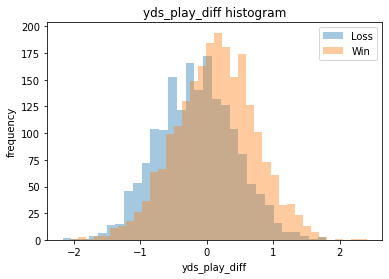

In [54]:
data_loss = master.loc[master['is_home_win']==0.0]
data_win = master.loc[master['is_home_win']==1.0]
sns.distplot(data_loss.yds_play_diff.dropna(),kde=False,label='Loss')
sns.distplot(data_win.yds_play_diff.dropna(),kde=False,label='Win')
plt.legend()
plt.title('yds_play_diff histogram')
plt.ylabel('frequency')
plt.show()

### Modelling

In [240]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, mean_absolute_error, mean_squared_error
from xgboost import XGBClassifier
import shap

In [308]:
def fit_and_score_model(mdl, X_train, X_val, y_train, y_val, type='regressor'):
    
    # Write some code to fit the model, and calculate evaluation metrics on
    # the validation set.
    # -------------------------------------------------------------------------
    # Fit the model
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_val)
    if type == 'classifier':
        y_proba = mdl.predict_proba(X_val) # For log_loss and roc_auc_score
        
        # Calculate various classification metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_proba[:, 1])  # Assuming binary classification
        logloss = log_loss(y_val, y_proba)
        
        # -------------------------------------------------------------------------\
        print('The precision score is {} and the recall score is {}'.format(precision, recall))
        return accuracy, precision, recall, f1, roc_auc, logloss
        
    else:
        train_score = mdl.score(X_train, y_train)
        test_score = mdl.score(X_val, y_val)
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)

        # -------------------------------------------------------------------------\
        print('The train score is {} and the test score is {}'.format(train_score, test_score))
        return train_score, test_score, mae, mse, rmse
    

def get_feature_importances(mdl, X_train):
    # Create an explainer object for the XGBoost model
    explainer = shap.Explainer(mdl)

    # Calculate SHAP values for all features in the training data
    shap_values = explainer.shap_values(X_train)

    # Summarize the SHAP values to obtain feature importances
    feature_importances = np.abs(shap_values).mean(axis=0)

    # Get the corresponding feature names
    feature_names = X_train.columns

    # Sort the feature importances in descending order
    sorted_indices = feature_importances.argsort()[::-1]
    sorted_importances = feature_importances[sorted_indices]
    sorted_feature_names = feature_names[sorted_indices]

    # Print the feature importances
    for feature_name, importance in zip(sorted_feature_names, sorted_importances):
        print(f"{feature_name}: {importance}")

    # Plot the feature importances
    shap.summary_plot(shap_values, X_train, feature_names=feature_names)

def print_heavily_correlated_features(df, threshold=0.7):
    corr = df.corr().abs()
    corr = corr[corr > threshold]
    print(corr.count().sort_values(ascending=False) - 1)

## Function to discover interacting features to engineer
def discover_interactions(interactiondf, target, function, threshold):
    # Looking for interaction effects within features by dividing
    base_corrs = interactiondf.corr()[target].drop(index=target)

    for feature1 in base_corrs.index:
        for feature2 in base_corrs.index:
            if feature2 != feature1:
                # divide the two features to create a new feature
                if function == 'divide':
                    new_feature = interactiondf[feature1] / interactiondf[feature2]
                else:
                    new_feature = interactiondf[feature1] * interactiondf[feature2]
                new_corr = np.abs(np.round(np.corrcoef(new_feature, interactiondf[target])[0,1], 3))
                corr1 = np.abs(np.round(base_corrs[feature1], 3))
                corr2 = np.abs(np.round(base_corrs[feature2], 3))
                # add a threshold of 0.02 to make sure that the improvement is meaningful
                if new_corr > max(corr1, corr2)+0.02:
                    # Only show significant correlations
                    if new_corr >= threshold:
                        print('{} {} combine to get correlation {} compared to {} {}'.format(
                            feature1, feature2, new_corr, corr1, corr2))

In [222]:
master = pd.read_csv('matchups_df.csv')

In [288]:
master.head()

,game_id,season,week,away_team,away_score,home_team,home_score,result,location,total,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,total_line,div_game,roof,surface,away_qb_id,home_qb_id,away_qb_name,home_qb_name,home_elo,away_elo,home_pass_elo_off,away_pass_elo_off,home_pass_elo_def,away_pass_elo_def,home_rush_ypc,away_rush_ypc,home_rush_epa_play,away_rush_epa_play,home_qbr,away_qbr,home_epa_play,away_epa_play,home_epa_play_def,away_epa_play_def,home_yds_play,away_yds_play,home_yds_play_def,away_yds_play_def,home_3d_conv,away_3d_conv,home_3d_conv_def,away_3d_conv_def,home_4d_conv,away_4d_conv,home_4d_conv_def,away_4d_conv_def,home_1D_drive,away_1D_drive,home_1D_drive_def,away_1D_drive_def,home_RZ_drive_diff,away_RZ_drive_diff,home_RZ_drive_def,away_RZ_drive_def,home_play_drive,away_play_drive,home_play_drive_def,away_play_drive_def,home_points_drive,away_points_drive,home_points_drive_def,away_points_drive_def,home_to_drive,away_to_drive,home_to_drive_def,away_to_drive_def,home_pen_yds_drive,away_pen_yds_drive,home_pen_yds_drive_def,away_pen_yds_drive_def,home_points_RZ,away_points_RZ,home_points_RZ_def,away_points_RZ_def,home_RZ_drive,away_RZ_drive,home_to_drive_diff,away_to_drive_diff,is_home_win,is_dome,is_grass,is_neutral
0,2008_01_WAS_NYG,2008,1,WAS,7.0,NYG,16.0,9.0,Home,23.0,7,7,NaN,NaN,4.5,41.5,1,outdoors,fieldturf,00-0023460,00-0022803,Jason Campbell,Eli Manning,1576.173384,1501.923151,1487.78922,1407.591750,1572.703369,1570.345894,4.377133,3.687500,-0.009694,-0.191930,55.878215,58.097479,0.011044,-0.051456,-0.028650,-0.058596,4.783150,4.774684,4.625287,4.538058,0.420664,0.393443,0.377358,0.350877,0.368421,0.388889,0.526316,0.588235,1.696970,1.557143,1.523013,1.478261,NaN,NaN,0.213389,0.260870,5.662338,5.547619,5.280335,5.429952,1.627706,1.390476,1.430962,1.371981,0.147186,0.147619,0.125523,0.125604,0.709957,-0.523810,-0.439331,0.014493,4.071429,3.981818,4.529412,4.166667,0.303030,0.261905,0.147186,0.147619,1.0,0.0,0.0,0.0
1,2008_01_DET_ATL,2008,1,DET,21.0,ATL,34.0,13.0,Home,55.0,7,7,NaN,NaN,-3.0,41.0,0,dome,fieldturf,00-0009311,00-0026143,Jon Kitna,Matt Ryan,1428.652224,1447.040436,1500.00000,1527.979749,1464.830408,1447.758112,3.948052,3.950920,-0.162897,-0.138491,0.000000,0.000000,-0.154458,-0.064758,0.013219,0.028232,4.615311,4.985521,5.258780,5.264808,0.362869,0.326316,0.371429,0.455399,0.368421,0.400000,0.523810,0.750000,1.269430,1.575130,1.696809,1.865285,NaN,NaN,0.250000,0.326425,5.248705,5.212435,5.696809,5.715026,1.181347,1.497409,1.723404,1.870466,0.124352,0.181347,0.127660,0.181347,-0.424870,0.373057,-0.085106,-0.186528,3.731707,3.840000,4.468085,4.476190,0.212435,0.259067,0.124352,0.181347,1.0,1.0,0.0,0.0
2,2008_01_CIN_BAL,2008,1,CIN,10.0,BAL,17.0,7.0,Home,27.0,7,7,NaN,NaN,-2.0,37.5,1,outdoors,sportturf,00-0021429,00-0026158,Carson Palmer,Joe Flacco,1473.280313,1492.463456,1500.00000,1637.536347,1579.865755,1485.793024,4.029148,3.740385,-0.114107,-0.081936,0.000000,59.168779,-0.106071,0.022765,0.006914,0.023780,4.412785,5.204673,4.690962,5.383799,0.384615,0.461538,0.366071,0.427861,0.523810,0.333333,0.538462,0.529412,1.515625,1.758242,1.282051,1.718232,NaN,NaN,0.251282,0.303867,5.645833,5.703297,5.061538,5.707182,1.255208,1.730769,1.615385,1.729282,0.182292,0.164835,0.117949,0.193370,0.161458,-0.247253,0.174359,-0.386740,3.717391,4.200000,3.857143,3.927273,0.239583,0.302198,0.182292,0.164835,1.0,0.0,0.0,0.0
3,2008_01_SEA_BUF,2008,1,SEA,10.0,BUF,34.0,24.0,Home,44.0,7,7,NaN,NaN,1.0,38.5,0,outdoors,astroplay,00-0007091,00-0025479,Matt Hasselbeck,Trent Edwards,1481.337609,1525.954271,1456.95579,1610.473411,1551.467745,1539.332042,4.017857,3.692964,-0.089351,-0.158056,0.000000,54.555752,-0.077822,-0.006852,0.033843,-0.100174,4.587384,5.089316,5.314730,4.702400,0.333333,0.337553,0.450893,0.380769,0.444444,0.400000,0.454545,0.300000,1.400000,1.512931,1.848837,1.372881,NaN,NaN,0.319767,0.203390,5.333333,5.189655,6.209302,5.080508,1.105556,1.560345,1.686047,1.262712,0.116667,0.120690,0.168605,0.1567

In [303]:
features = ['away_rest','home_rest','spread_line','total_line','div_game','home_elo', 'away_elo','home_pass_elo_off','away_pass_elo_off',
            'home_pass_elo_def','away_pass_elo_def','home_rush_ypc','away_rush_ypc','home_rush_epa_play','away_rush_epa_play','home_qbr','away_qbr',
            'home_epa_play','away_epa_play','home_epa_play_def','away_epa_play_def','home_yds_play','away_yds_play','home_yds_play_def',
            'away_yds_play_def','home_3d_conv','away_3d_conv','home_3d_conv_def','away_3d_conv_def','home_4d_conv',
            'away_4d_conv','home_4d_conv_def','away_4d_conv_def','home_1D_drive','away_1D_drive','home_1D_drive_def','away_1D_drive_def',
            'home_points_drive','away_points_drive','home_points_drive_def','away_points_drive_def','home_to_drive',
            'away_to_drive','home_to_drive_def','away_to_drive_def','home_pen_yds_drive','away_pen_yds_drive','home_pen_yds_drive_def',
            'away_pen_yds_drive_def','home_points_RZ','away_points_RZ','home_points_RZ_def','away_points_RZ_def','is_dome','is_grass']

# ['home_RZ_drive','away_RZ_drive','home_RZ_drive_def','away_RZ_drive_def','home_play_drive','away_play_drive','home_play_drive_def',
#  'away_play_drive_def']

In [309]:
df_train = master[master.season<2020]
interactiondf = df_train[sorted(features) + ['is_home_win']]

In [314]:
discover_interactions(interactiondf, 'is_home_win', 'divide', 0.2)

away_elo away_pass_elo_off combine to get correlation 0.254 compared to 0.195 0.158
away_elo home_elo combine to get correlation 0.309 compared to 0.195 0.224
away_elo home_pass_elo_def combine to get correlation 0.229 compared to 0.195 0.115
away_elo home_pass_elo_off combine to get correlation 0.273 compared to 0.195 0.184
away_pass_elo_def home_elo combine to get correlation 0.246 compared to 0.1 0.224
away_pass_elo_def home_pass_elo_off combine to get correlation 0.212 compared to 0.1 0.184
away_pass_elo_off away_elo combine to get correlation 0.255 compared to 0.158 0.195

invalid value encountered in subtract
invalid value encountered in reduce



home_elo away_elo combine to get correlation 0.307 compared to 0.224 0.195
home_elo away_pass_elo_def combine to get correlation 0.245 compared to 0.224 0.1
home_pass_elo_def away_elo combine to get correlation 0.23 compared to 0.115 0.195
home_pass_elo_off away_elo combine to get correlation 0.272 compared to 0.184 0.195
home_pass_elo_off away_pass_elo_def combine to get correlation 0.213 compared to 0.184 0.1


In [310]:
interactiondf

,away_1D_drive,away_1D_drive_def,away_3d_conv,away_3d_conv_def,away_4d_conv,away_4d_conv_def,away_elo,away_epa_play,away_epa_play_def,away_pass_elo_def,away_pass_elo_off,away_pen_yds_drive,away_pen_yds_drive_def,away_points_RZ,away_points_RZ_def,away_points_drive,away_points_drive_def,away_qbr,away_rest,away_rush_epa_play,away_rush_ypc,away_to_drive,away_to_drive_def,away_yds_play,away_yds_play_def,div_game,home_1D_drive,home_1D_drive_def,home_3d_conv,home_3d_conv_def,home_4d_conv,home_4d_conv_def,home_elo,home_epa_play,home_epa_play_def,home_pass_elo_def,home_pass_elo_off,home_pen_yds_drive,home_pen_yds_drive_def,home_points_RZ,home_points_RZ_def,home_points_drive,home_points_drive_def,home_qbr,home_rest,home_rush_epa_play,home_rush_ypc,home_to_drive,home_to_drive_def,home_yds_play,home_yds_play_def,is_dome,is_grass,spread_line,total_line,is_home_win
0,1.557143,1.478261,0.393443,0.350877,0.388889,0.588235,1501.923151,-0.051456,-0.058596,1570.345894,1407.591750,-0.523810,0.014493,3.981818,4.166667,1.390476,1.371981,58.097479,7,-0.191930,3.687500,0.147619,0.125604,4.774684,4.538058,1,1.696970,1.523013,0.420664,0.377358,0.368421,0.526316,1576.173384,0.011044,-0.028650,1572.703369,1487.789220,0.709957,-0.439331,4.071429,4.529412,1.627706,1.430962,55.878215,7,-0.009694,4.377133,0.147186,0.125523,4.783150,4.625287,0.0,0.0,4.5,41.5,1.0
1,1.575130,1.865285,0.326316,0.455399,0.400000,0.750000,1447.040436,-0.064758,0.028232,1447.758112,1527.979749,0.373057,-0.186528,3.840000,4.476190,1.497409,1.870466,0.000000,7,-0.138491,3.950920,0.181347,0.181347,4.985521,5.264808,0,1.269430,1.696809,0.362869,0.371429,0.368421,0.523810,1428.652224,-0.154458,0.013219,1464.830408,1500.000000,-0.424870,-0.085106,3.731707,4.468085,1.181347,1.723404,0.000000,7,-0.162897,3.948052,0.124352,0.127660,4.615311,5.258780,1.0,0.0,-3.0,41.0,1.0
2,1.758242,1.718232,0.461538,0.427861,0.333333,0.529412,1492.463456,0.022765,0.023780,1485.793024,1637.536347,-0.247253,-0.386740,4.200000,3.927273,1.730769,1.729282,59.168779,7,-0.081936,3.740385,0.164835,0.193370,5.204673,5.383799,1,1.515625,1.282051,0.384615,0.366071,0.523810,0.538462,1473.280313,-0.106071,0.006914,1579.865755,1500.000000,0.161458,0.174359,3.717391,3.857143,1.255208,1.615385,0.000000,7,-0.114107,4.029148,0.182292,0.117949,4.412785,4.690962,0.0,0.0,-2.0,37.5,1.0
3,1.512931,1.372881,0.337553,0.380769,0.400000,0.300000,1525.954271,-0.006852,-0.100174,1539.332042,1610.473411,0.383621,-0.779661,4.339286,4.375000,1.560345,1.262712,54.555752,7,-0.158056,3.692964,0.120690,0.156780,5.089316,4.702400,0,1.400000,1.848837,0.333333,0.450893,0.444444,0.454545,1481.337609,-0.077822,0.033843,1551.467745,1456.955790,-0.383333,-0.122093,3.794118,3.763636,1.105556,1.686047,0.000000,7,-0.089351,4.017857,0.116667,0.168605,4.587384,5.314730,0.0,0.0,1.0,38.5,1.0
4,1.630682,1.829412,0.376106,0.421801,0.476190,0.800000,1447.644319,-0.040519,0.056136,1522.181696,1559.837695,0.250000,-0.947059,3.551020,4.615385,1.312500,1.676471,0.000000,7,-0.077762,3.813901,0.142045,0.123529,4.421743,5.032197,1,1.581006,1.802260,0.371560,0.471154,0.590909,0.600000,1389.301463,-0.043572,0.126847,1530.953473,1578.122400,-0.709497,-0.197740,4.000000,4.903846,1.212291,2.101695,0.000000,7,-0.037322,3.987212,0.156425,0.118644,4.422819,5.312318,0.0,1.0,-3.0,36.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3199,2.016575,2.032967,0.436893,0.488789,0.500000,0.411765,1577.075856,0.026700,0.030790,1528.921231,1500.000000,-0.685083,-0.994505,4.690909,4.941176,1.878453,1.928571,64.286254,8,-0.003609,4.603854,0.116022,0.131868,5.290378,5.646259,0,2.077844,2.060606,0.475936,0.371287,0.600000,0.516129,1637.416852,0.117787,-0.041201,1662.342159,1659.444861,0.215569,0.648485,4.375000,3.927273,2.335329,1.618182,76.221637,14,-0.053044,4.184000,0.083832,0.127273,5.769011,4.964539,0.0

In [304]:
# Split the data into training and testing sets
df_train = master[master.season<2020]
df_test = master[master.season>=2020]

# Write your code here.
# Partition the training data into features and target
X_train = df_train[sorted(features)]
y_train = df_train.is_home_win

# Partition the testing data into features and target
X_test = df_test[sorted(features)]
y_test = df_test.is_home_win

In [293]:
print_heavily_correlated_features(X_train, threshold=0.7)

home_RZ_drive          6
away_play_drive_def    6
away_play_drive        6
away_yds_play          6
away_RZ_drive          6
                      ..
home_4d_conv           0
home_4d_conv_def       0
home_elo               0
home_pen_yds_drive     0
total_line             0
Length: 63, dtype: int64


In [302]:
X_train.corr().loc['away_RZ_drive',:].sort_values()

spread_line          -0.391435
away_to_drive        -0.138167
home_epa_play_def    -0.055513
away_epa_play_def    -0.037358
home_rush_epa_play   -0.026617
                        ...   
away_yds_play         0.737865
away_3d_conv          0.754059
away_1D_drive         0.847848
away_points_drive     0.873107
away_RZ_drive         1.000000
Name: away_RZ_drive, Length: 63, dtype: float64

In [305]:
# Train basic xgboost classifier
mdl = XGBClassifier()
fit_and_score_model(mdl, X_train, X_test, y_train, y_test, type='classifier')

The precision score is 0.6593406593406593 and the recall score is 0.6802721088435374


(0.6467780429594272,
 0.6593406593406593,
 0.6802721088435374,
 0.6696428571428571,
 0.6842989084802686,
 0.774367981043123)

spread_line: 0.8464049100875854
home_yds_play_def: 0.17154602706432343
away_to_drive: 0.1543826013803482
away_qbr: 0.1517200767993927
away_yds_play_def: 0.14327745139598846
away_epa_play_def: 0.1351330429315567
home_pass_elo_def: 0.13327156007289886
home_pen_yds_drive: 0.131515234708786
home_elo: 0.1307339370250702
home_points_drive_def: 0.130192831158638
home_qbr: 0.12579162418842316
home_3d_conv: 0.1249617412686348
away_pen_yds_drive: 0.12334197014570236
away_3d_conv_def: 0.12330545485019684
away_epa_play: 0.11931043118238449
home_3d_conv_def: 0.11899738758802414
home_rush_epa_play: 0.11758197844028473
away_pass_elo_off: 0.116863913834095
away_4d_conv_def: 0.11497486382722855
home_to_drive: 0.11385905742645264
home_yds_play: 0.11313659697771072
away_points_RZ: 0.11097761988639832
away_points_RZ_def: 0.11045686155557632
home_points_RZ_def: 0.1098257452249527
home_pen_yds_drive_def: 0.10715881735086441
away_to_drive_def: 0.1048523560166359
home_rush_ypc: 0.09643052518367767
away_rush_y

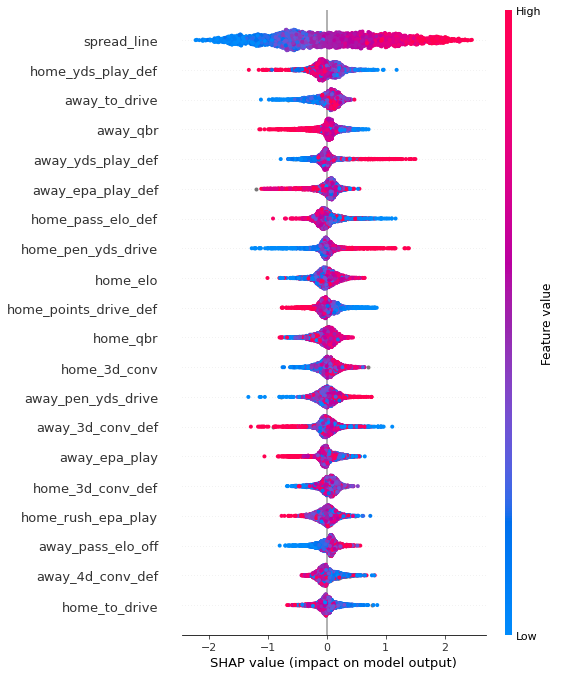

In [306]:
get_feature_importances(mdl, X_train)

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Actual')]

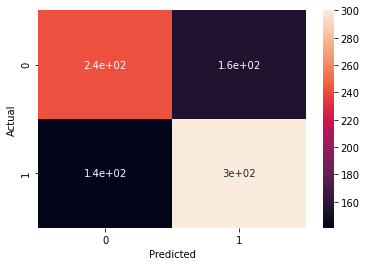

In [307]:
from sklearn.metrics import confusion_matrix

y_pred = mdl.predict(X_test)
cfm = confusion_matrix(y_true=y_test, y_pred=y_pred)
ax = sns.heatmap(cfm, annot=True)
ax.set(xlabel='Predicted', ylabel='Actual')

### Making Predictions

In [257]:
# Manually imported sheet of starters
starters = pd.read_csv('starting_qbs.csv')

In [258]:
starters.head()

,Week,Team,passer,passer_id
0,1,NE,M.Jones,00-0036972
1,1,MIA,T.Tagovailoa,00-0036212
2,1,NYJ,A.Rodgers,00-0023459
3,1,BUF,J.Allen,00-0034857
4,1,BAL,L.Jackson,00-0034796


In [259]:
upcoming.head()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_coach,home_coach,referee,stadium_id,stadium,home_qb_name,home_qb_id,away_qb_name,away_qb_id
0,2023_01_DET_KC,2023,REG,1,2023-09-07,Thursday,20:20,DET,NaN,KC,NaN,Home,NaN,NaN,NaN,2023090700,NaN,NaN,202309070kan,NaN,NaN,NaN,7,7,230.0,-285.0,6.5,-110.0,-110.0,54.0,-110.0,-110.0,0,outdoors,grass,NaN,NaN,Dan Campbell,Andy Reid,NaN,KAN00,GEHA Field at Arrowhead Stadium,P.Mahomes,00-0033873,J.Goff,00-0033106
1,2023_01_CAR_ATL,2023,REG,1,2023-09-10,Sunday,13:00,CAR,NaN,ATL,NaN,Home,NaN,NaN,NaN,2023091000,NaN,NaN,202309100atl,NaN,NaN,NaN,7,7,160.0,-192.0,3.5,-108.0,-112.0,39.5,-108.0,-112.0,1,NaN,fieldturf,NaN,NaN,Frank Reich,Arthur Smith,NaN,ATL97,Mercedes-Benz Stadium,D.Ridder,00-0038122,B.Young,NaN
2,2023_01_HOU_BAL,2023,REG,1,2023-09-10,Sunday,13:00,HOU,NaN,BAL,NaN,Home,NaN,NaN,NaN,2023091001,NaN,NaN,202309100rav,NaN,NaN,NaN,7,7,370.0,-485.0,10.0,-110.0,-110.0,43.5,-110.0,-110.0,0,outdoors,grass,NaN,NaN,DeMeco Ryans,John Harbaugh,NaN,BAL00,M&T Bank Stadium,L.Jackson,00-0034796,C.Stroud,NaN
3,2023_01_CIN_CLE,2023,REG,1,2023-09-10,Sunday,13:00,CIN,NaN,CLE,NaN,Home,NaN,NaN,NaN,2023091002,NaN,NaN,202309100cle,NaN,NaN,NaN,7,7,-135.0,114.0,-2.5,-110.0,-110.0,47.5,-110.0,-110.0,1,outdoors,grass,NaN,NaN,Zac Taylor,Kevin Stefanski,NaN,CLE00,FirstEnergy Stadium,D.Watson,00-0033537,J.Burrow,00-0036442
4,2023_01_JAX_IND,2023,REG,1,2023-09-10,Sunday,13:00,JAX,NaN,IND,NaN,Home,NaN,NaN,NaN,2023091003,NaN,NaN,202309100clt,NaN,NaN,NaN,7,7,-230.0,185.0,-5.0,-112.0,-108.0,45.0,-110.0,-110.0,1,NaN,fieldturf,NaN,NaN,Doug Pederson,Shane Steichen,NaN,IND00,Lucas Oil Stadium,A.Richardson,NaN,T.Lawrence,00-0036971


In [260]:
# merge in starting QB
upcoming = upcoming.drop(['away_qb_id','home_qb_id','away_qb_name','home_qb_name'],axis=1)

upcoming = upcoming.merge(starters[['Team','passer','passer_id']], how='left', left_on='home_team', right_on='Team').rename({'passer':\
    'home_qb_name', 'passer_id':'home_qb_id'},axis=1)

upcoming = upcoming.drop(['Team'],axis=1)

upcoming = upcoming.merge(starters[['Team','passer','passer_id']], how='left', left_on='away_team', right_on='Team').rename({'passer':\
    'away_qb_name', 'passer_id':'away_qb_id'},axis=1)

upcoming = upcoming.drop(['Team'],axis=1)

In [261]:
upcoming.head()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_coach,home_coach,referee,stadium_id,stadium,home_qb_name,home_qb_id,away_qb_name,away_qb_id
0,2023_01_DET_KC,2023,REG,1,2023-09-07,Thursday,20:20,DET,NaN,KC,NaN,Home,NaN,NaN,NaN,2023090700,NaN,NaN,202309070kan,NaN,NaN,NaN,7,7,230.0,-285.0,6.5,-110.0,-110.0,54.0,-110.0,-110.0,0,outdoors,grass,NaN,NaN,Dan Campbell,Andy Reid,NaN,KAN00,GEHA Field at Arrowhead Stadium,P.Mahomes,00-0033873,J.Goff,00-0033106
1,2023_01_CAR_ATL,2023,REG,1,2023-09-10,Sunday,13:00,CAR,NaN,ATL,NaN,Home,NaN,NaN,NaN,2023091000,NaN,NaN,202309100atl,NaN,NaN,NaN,7,7,160.0,-192.0,3.5,-108.0,-112.0,39.5,-108.0,-112.0,1,NaN,fieldturf,NaN,NaN,Frank Reich,Arthur Smith,NaN,ATL97,Mercedes-Benz Stadium,D.Ridder,00-0038122,B.Young,NaN
2,2023_01_HOU_BAL,2023,REG,1,2023-09-10,Sunday,13:00,HOU,NaN,BAL,NaN,Home,NaN,NaN,NaN,2023091001,NaN,NaN,202309100rav,NaN,NaN,NaN,7,7,370.0,-485.0,10.0,-110.0,-110.0,43.5,-110.0,-110.0,0,outdoors,grass,NaN,NaN,DeMeco Ryans,John Harbaugh,NaN,BAL00,M&T Bank Stadium,L.Jackson,00-0034796,C.Stroud,NaN
3,2023_01_CIN_CLE,2023,REG,1,2023-09-10,Sunday,13:00,CIN,NaN,CLE,NaN,Home,NaN,NaN,NaN,2023091002,NaN,NaN,202309100cle,NaN,NaN,NaN,7,7,-135.0,114.0,-2.5,-110.0,-110.0,47.5,-110.0,-110.0,1,outdoors,grass,NaN,NaN,Zac Taylor,Kevin Stefanski,NaN,CLE00,FirstEnergy Stadium,D.Watson,00-0033537,J.Burrow,00-0036442
4,2023_01_JAX_IND,2023,REG,1,2023-09-10,Sunday,13:00,JAX,NaN,IND,NaN,Home,NaN,NaN,NaN,2023091003,NaN,NaN,202309100clt,NaN,NaN,NaN,7,7,-230.0,185.0,-5.0,-112.0,-108.0,45.0,-110.0,-110.0,1,NaN,fieldturf,NaN,NaN,Doug Pederson,Shane Steichen,NaN,IND00,Lucas Oil Stadium,A.Richardson,NaN,T.Lawrence,00-0036971


In [270]:
# grab a main df of all important info
newseason = upcoming[['game_id','season','week','away_team','away_score','home_team','home_score','result','location','total','away_rest','home_rest','away_moneyline',\
    'home_moneyline','spread_line','total_line','div_game','roof','surface','away_qb_id','home_qb_id','away_qb_name','home_qb_name']]

In [271]:
newseason.head()

,game_id,season,week,away_team,away_score,home_team,home_score,result,location,total,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,total_line,div_game,roof,surface,away_qb_id,home_qb_id,away_qb_name,home_qb_name
0,2023_01_DET_KC,2023,1,DET,NaN,KC,NaN,NaN,Home,NaN,7,7,230.0,-285.0,6.5,54.0,0,outdoors,grass,00-0033106,00-0033873,J.Goff,P.Mahomes
1,2023_01_CAR_ATL,2023,1,CAR,NaN,ATL,NaN,NaN,Home,NaN,7,7,160.0,-192.0,3.5,39.5,1,NaN,fieldturf,NaN,00-0038122,B.Young,D.Ridder
2,2023_01_HOU_BAL,2023,1,HOU,NaN,BAL,NaN,NaN,Home,NaN,7,7,370.0,-485.0,10.0,43.5,0,outdoors,grass,NaN,00-0034796,C.Stroud,L.Jackson
3,2023_01_CIN_CLE,2023,1,CIN,NaN,CLE,NaN,NaN,Home,NaN,7,7,-135.0,114.0,-2.5,47.5,1,outdoors,grass,00-0036442,00-0033537,J.Burrow,D.Watson
4,2023_01_JAX_IND,2023,1,JAX,NaN,IND,NaN,NaN,Home,NaN,7,7,-230.0,185.0,-5.0,45.0,1,NaN,fieldturf,00-0036971,NaN,T.Lawrence,A.Richardson


In [264]:
historical_elo_df

,Team,Season,Week,Elo
0,MIN,1999,1,1516.000000
0,ATL,1999,1,1484.000000
0,KC,1999,1,1484.000000
0,CHI,1999,1,1516.000000
0,PIT,1999,1,1516.000000
...,...,...,...,...
30,STL,2023,0,1500.000000
31,HOU,2023,0,1456.670979
32,LA,2023,0,1488.870084
33,LAC,2023,0,1503.232672


In [272]:
# Calculate mean Elo at the end of the season
mean_elo = calculate_mean_elo(elo_df)

# Regress each team's Elo ratings towards the mean
elo_df = regress_to_mean(elo_df, mean_elo, regression_weight=1/3)

elo_df_temp = elo_df.copy()

elo_df_temp['Week'] = 0
elo_df_temp['Season'] = newseason.loc[0,'season']

historical_elo_df = pd.concat([historical_elo_df,elo_df_temp])

In [273]:
# Calculate mean Elo at the end of the season
mean_elo = calculate_mean_elo(elo_def)

# Regress each team's Elo ratings towards the mean
elo_def = regress_to_mean(elo_def, mean_elo, regression_weight=1/3)

elo_def_temp = elo_def.copy()

elo_def_temp['Week'] = 0
elo_def_temp['Season'] = newseason.loc[0,'season']

historical_elo_def = pd.concat([historical_elo_def,elo_def_temp])

In [275]:
# Loop through matchups in master and populate cols (features individually)
newseason.loc[:,'home_elo'] = np.nan
newseason.loc[:,'away_elo'] = np.nan
newseason.loc[:,'home_pass_elo_off'] = np.nan # QB elo Def elo difference
newseason.loc[:,'away_pass_elo_off'] = np.nan # QB elo Def elo difference
newseason.loc[:,'home_pass_elo_def'] = np.nan # QB elo Def elo difference
newseason.loc[:,'away_pass_elo_def'] = np.nan # QB elo Def elo difference
newseason.loc[:,'home_rush_ypc'] = np.nan
newseason.loc[:,'away_rush_ypc'] = np.nan
newseason.loc[:,'home_rush_epa_play'] = np.nan
newseason.loc[:,'away_rush_epa_play'] = np.nan
newseason.loc[:,'home_qbr'] = np.nan
newseason.loc[:,'away_qbr'] = np.nan
newseason.loc[:,'home_epa_play'] = np.nan 
newseason.loc[:,'away_epa_play'] = np.nan 
newseason.loc[:,'home_epa_play_def'] = np.nan
newseason.loc[:,'away_epa_play_def'] = np.nan
newseason.loc[:,'home_yds_play'] = np.nan
newseason.loc[:,'away_yds_play'] = np.nan
newseason.loc[:,'home_yds_play_def'] = np.nan
newseason.loc[:,'away_yds_play_def'] = np.nan
newseason.loc[:,'home_3d_conv'] = np.nan
newseason.loc[:,'away_3d_conv'] = np.nan
newseason.loc[:,'home_3d_conv_def'] = np.nan
newseason.loc[:,'away_3d_conv_def'] = np.nan
newseason.loc[:,'home_4d_conv'] = np.nan
newseason.loc[:,'away_4d_conv'] = np.nan
newseason.loc[:,'home_4d_conv_def'] = np.nan
newseason.loc[:,'away_4d_conv_def'] = np.nan
newseason.loc[:,'home_1D_drive'] = np.nan
newseason.loc[:,'away_1D_drive'] = np.nan
newseason.loc[:,'home_1D_drive_def'] = np.nan
newseason.loc[:,'away_1D_drive_def'] = np.nan
newseason.loc[:,'home_RZ_drive'] = np.nan
newseason.loc[:,'away_RZ_drive'] = np.nan
newseason.loc[:,'home_RZ_drive_def'] = np.nan
newseason.loc[:,'away_RZ_drive_def'] = np.nan
newseason.loc[:,'home_play_drive'] = np.nan
newseason.loc[:,'away_play_drive'] = np.nan
newseason.loc[:,'home_play_drive_def'] = np.nan
newseason.loc[:,'away_play_drive_def'] = np.nan
newseason.loc[:,'home_points_drive'] = np.nan
newseason.loc[:,'away_points_drive'] = np.nan
newseason.loc[:,'home_points_drive_def'] = np.nan
newseason.loc[:,'away_points_drive_def'] = np.nan
newseason.loc[:,'home_to_drive'] = np.nan
newseason.loc[:,'away_to_drive'] = np.nan
newseason.loc[:,'home_to_drive_def'] = np.nan
newseason.loc[:,'away_to_drive_def'] = np.nan
newseason.loc[:,'home_pen_yds_drive'] = np.nan
newseason.loc[:,'away_pen_yds_drive'] = np.nan
newseason.loc[:,'home_pen_yds_drive_def'] = np.nan
newseason.loc[:,'away_pen_yds_drive_def'] = np.nan
newseason.loc[:,'home_points_RZ'] = np.nan
newseason.loc[:,'away_points_RZ'] = np.nan
newseason.loc[:,'home_points_RZ_def'] = np.nan
newseason.loc[:,'away_points_RZ_def'] = np.nan

# Change dtypes
newseason['season'] = newseason['season'].astype(int)
newseason['week'] = newseason['week'].astype(int)
historical_elo_df['Season'] = historical_elo_df['Season'].astype(int)
historical_elo_df['Week'] = historical_elo_df['Week'].astype(int)

newseason = newseason.reset_index(drop=True)

current_week = newseason.loc[0,'week']

for i,row in newseason.iterrows():
    # Populate elo differences
    newseason.loc[i,'home_elo'], newseason.loc[i,'away_elo'] = get_elo(row['home_team'],row['season'],current_week,historical_elo_df), get_elo(row['away_team'],row['season'],current_week,historical_elo_df)
        
    newseason.loc[i,'home_pass_elo_off'], newseason.loc[i,'away_pass_elo_off'] = get_qb_elo(row['home_qb_id'],row['season'],current_week,historical_elo_qb), get_qb_elo(row['away_qb_id'],row['season'],current_week,historical_elo_qb)
    
    newseason.loc[i,'home_pass_elo_def'], newseason.loc[i,'away_pass_elo_def'] = get_elo(row['home_team'],row['season'],current_week,historical_elo_def), get_elo(row['away_team'],row['season'],current_week,historical_elo_def)
    
    # Populate other stats
    newseason.loc[i,'home_rush_ypc'] = get_value(weekly_sum, row['season'], current_week, row['home_team'], 'recent_team', 'rushing_yards', \
        'carries')
    newseason.loc[i,'away_rush_ypc'] = get_value(weekly_sum, row['season'], \
        current_week, row['away_team'], 'recent_team', 'rushing_yards', 'carries')
    
    newseason.loc[i,'home_rush_epa_play'] = get_value(weekly_sum, row['season'], current_week, row['home_team'], 'recent_team', 'rushing_epa', \
        'carries') 
    newseason.loc[i,'away_rush_epa_play'] = get_value(weekly_sum, row['season'], \
        current_week, row['away_team'], 'recent_team', 'rushing_epa', 'carries')
    
    newseason.loc[i,'home_qbr'] = get_qbr(qbr, row['season'], current_week, row['home_qb_id'])
    newseason.loc[i,'away_qbr'] = get_qbr(qbr, row['season'], current_week, row['away_qb_id'])
    
    newseason.loc[i,'home_epa_play'] = get_value(off_yardage, row['season'], current_week, row['home_team'], 'posteam', 'epa', 'play')
    newseason.loc[i,'away_epa_play'] = get_value(off_yardage, row['season'], current_week, row['away_team'], 'posteam', 'epa', 'play')
    
    newseason.loc[i,'home_epa_play_def'] = get_value(off_yardage, row['season'], current_week, row['home_team'], 'defteam', 'epa', 'play')
    newseason.loc[i,'away_epa_play_def'] = get_value(off_yardage, row['season'], current_week, row['away_team'], 'defteam', 'epa', 'play')
    
    newseason.loc[i,'home_yds_play'] = get_value(off_yardage, row['season'], current_week, row['home_team'], 'posteam', 'yards_gained', 'play')
    newseason.loc[i,'away_yds_play'] = get_value(off_yardage, row['season'], current_week, row['away_team'], 'posteam', 'yards_gained', 'play')
    
    newseason.loc[i,'home_yds_play_def'] = get_value(off_yardage, row['season'], current_week, row['home_team'], 'defteam', 'yards_gained', 'play')
    newseason.loc[i,'away_yds_play_def']= get_value(off_yardage, row['season'], current_week, row['away_team'], 'defteam', 'yards_gained', 'play')
    
    newseason.loc[i,'home_3d_conv'] = get_value(off_yardage, row['season'], current_week, row['home_team'], 'posteam', 'third_down_converted', \
                                             'third_down_total')
    newseason.loc[i,'away_3d_conv'] = get_value(off_yardage, row['season'], \
        current_week, row['away_team'], 'posteam', 'third_down_converted', 'third_down_total')
    
    newseason.loc[i,'home_3d_conv_def'] = get_value(off_yardage, row['season'], current_week, row['home_team'], 'defteam', 'third_down_converted',\
                                                 'third_down_total') 
    newseason.loc[i,'away_3d_conv_def'] = get_value(off_yardage, row['season'], \
        current_week, row['away_team'], 'defteam', 'third_down_converted', 'third_down_total')
    
    newseason.loc[i,'home_4d_conv'] = get_value(off_yardage, row['season'], current_week, row['home_team'], 'posteam', 'fourth_down_converted', \
                                             'fourth_down_total')
    newseason.loc[i,'away_4d_conv'] = get_value(off_yardage, row['season'], \
        current_week, row['away_team'], 'posteam', 'fourth_down_converted', 'fourth_down_total')
    
    newseason.loc[i,'home_4d_conv_def'] = get_value(off_yardage, row['season'],current_week, row['home_team'], 'defteam', \
                                                 'fourth_down_converted', 'fourth_down_total') 
    newseason.loc[i,'away_4d_conv_def'] = get_value(off_yardage, row['season'], \
        current_week, row['away_team'], 'defteam', 'fourth_down_converted', 'fourth_down_total')
    
    newseason.loc[i,'home_1D_drive'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'posteam', 'drive_first_downs', \
                                              'fixed_drive')
    newseason.loc[i,'away_1D_drive'] = get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'posteam', 'drive_first_downs', 'fixed_drive')
    
    newseason.loc[i,'home_1D_drive_def'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'defteam', 'drive_first_downs', \
                                                  'fixed_drive')
    newseason.loc[i,'away_1D_drive_def'] = get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'defteam', 'drive_first_downs', 'fixed_drive')
    
    newseason.loc[i,'home_RZ_drive'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'posteam', 'drive_inside20', \
                                              'fixed_drive')
    newseason.loc[i,'away_RZ_drive'] = get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'posteam', 'drive_inside20', 'fixed_drive')
    
    newseason.loc[i,'home_RZ_drive_def'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'defteam', 'drive_inside20', \
                                                  'fixed_drive')
    newseason.loc[i,'away_RZ_drive_def'] = get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'defteam', 'drive_inside20', 'fixed_drive')
    
    newseason.loc[i,'home_play_drive'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'posteam', 'drive_play_count', \
                                                'fixed_drive')
    newseason.loc[i,'away_play_drive'] = get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'posteam', 'drive_play_count', 'fixed_drive')
    
    newseason.loc[i,'home_play_drive_def'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'defteam', 'drive_play_count', \
                                                    'fixed_drive')
    newseason.loc[i,'away_play_drive_def'] = get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'defteam', 'drive_play_count', 'fixed_drive')
    
    newseason.loc[i,'home_points_drive'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'posteam', 'drive_points', \
                                                  'fixed_drive')
    newseason.loc[i,'away_points_drive'] = get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'posteam', 'drive_points', 'fixed_drive')
    
    newseason.loc[i,'home_points_drive_def'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'defteam', 'drive_points', \
                                                      'fixed_drive')
    newseason.loc[i,'away_points_drive_def'] = get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'defteam', 'drive_points', 'fixed_drive')
    
    newseason.loc[i,'home_to_drive'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'posteam', 'drive_turnover', \
                                                   'fixed_drive')
    newseason.loc[i,'away_to_drive'] = get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'posteam', 'drive_turnover', 'fixed_drive')
    
    newseason.loc[i,'home_to_drive_def'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'defteam', 'drive_turnover',\
                                                   'fixed_drive')
    newseason.loc[i,'away_to_drive_def'] = get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'defteam', 'drive_turnover', 'fixed_drive')
    
    newseason.loc[i,'home_pen_yds_drive'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'posteam', \
                                                   'drive_yards_penalized', 'fixed_drive')
    newseason.loc[i,'away_pen_yds_drive'] = get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'posteam', 'drive_yards_penalized', 'fixed_drive')
    
    newseason.loc[i,'home_pen_yds_drive_def'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'defteam', \
                                                       'drive_yards_penalized', 'fixed_drive')
    newseason.loc[i,'away_pen_yds_drive_def'] = get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'defteam', 'drive_yards_penalized', 'fixed_drive')
    
    newseason.loc[i,'home_points_RZ'] = get_value(rz_data, row['season'], current_week, row['home_team'], 'posteam', 'drive_points', \
                                               'drive_inside20')
    newseason.loc[i,'away_points_RZ'] = get_value(rz_data, row['season'], \
        current_week, row['away_team'], 'posteam', 'drive_points', 'drive_inside20')
    
    newseason.loc[i,'home_points_RZ_def'] = get_value(rz_data, row['season'], current_week, row['home_team'], 'defteam', 'drive_points', \
                                                   'drive_inside20')
    newseason.loc[i,'away_points_RZ_def'] = get_value(rz_data, row['season'], \
        current_week, row['away_team'], 'defteam', 'drive_points', 'drive_inside20')
    

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in dou

In [212]:
# Loop through matchups in newseason and populate cols (everything is home-away unless otherwise stated)
newseason.loc[:,'elo_diff'] = np.nan
newseason.loc[:,'home_pass_elo_diff'] = np.nan # QB elo Def elo difference
newseason.loc[:,'away_pass_elo_diff'] = np.nan # QB elo Def elo difference
newseason.loc[:,'rush_ypc_diff'] = np.nan # Difference between two teams
newseason.loc[:,'rush_epa_play_diff'] = np.nan # Difference between two teams
newseason.loc[:,'qbr_diff'] = np.nan # Difference between two teams
# Rest all off vs def diff
newseason.loc[:,'epa_play_diff'] = np.nan 
newseason.loc[:,'epa_play_diff_def'] = np.nan
newseason.loc[:,'yds_play_diff'] = np.nan
newseason.loc[:,'yds_play_diff_def'] = np.nan
newseason.loc[:,'3d_conv_diff'] = np.nan
newseason.loc[:,'3d_conv_diff_def'] = np.nan
newseason.loc[:,'4d_conv_diff'] = np.nan
newseason.loc[:,'4d_conv_diff_def'] = np.nan
newseason.loc[:,'1D_drive_diff'] = np.nan
newseason.loc[:,'1D_drive_diff_def'] = np.nan
newseason.loc[:,'RZ_drive_diff'] = np.nan
newseason.loc[:,'RZ_drive_diff_def'] = np.nan
newseason.loc[:,'play_drive_diff'] = np.nan
newseason.loc[:,'play_drive_diff_def'] = np.nan
newseason.loc[:,'points_drive_diff'] = np.nan
newseason.loc[:,'points_drive_diff_def'] = np.nan
newseason.loc[:,'to_drive_diff'] = np.nan
newseason.loc[:,'to_drive_diff_def'] = np.nan
newseason.loc[:,'pen_yds_drive_diff'] = np.nan
newseason.loc[:,'pen_yds_drive_diff_def'] = np.nan
newseason.loc[:,'points_RZ_diff'] = np.nan
newseason.loc[:,'points_RZ_diff_def'] = np.nan

# Change dtypes
newseason['season'] = newseason['season'].astype(int)
newseason['week'] = newseason['week'].astype(int)
historical_elo_df['Season'] = historical_elo_df['Season'].astype(int)
historical_elo_df['Week'] = historical_elo_df['Week'].astype(int)

newseason = newseason.reset_index(drop=True)

current_week = newseason.loc[0,'week']

for i,row in newseason.iterrows():
    # Populate elo differences
    newseason.loc[i,'elo_diff'] = get_elo(row['home_team'],row['season'],current_week,historical_elo_df) - get_elo(row['away_team'],row['season'],current_week,historical_elo_df)
        
    newseason.loc[i,'home_pass_elo_diff'] = get_qb_elo(row['home_qb_id'],row['season'],current_week,historical_elo_qb) - get_elo(row['away_team'],row['season'],current_week,historical_elo_def)
    
    newseason.loc[i,'away_pass_elo_diff'] = get_qb_elo(row['away_qb_id'],row['season'],current_week,historical_elo_qb) - get_elo(row['home_team'],row['season'],current_week,historical_elo_def)
    
    # Populate other stats
    newseason.loc[i,'rush_ypc_diff'] = get_value(weekly_sum, row['season'], current_week, row['home_team'], 'recent_team', 'rushing_yards', 'carries') - get_value(weekly_sum, row['season'], \
        current_week, row['away_team'], 'recent_team', 'rushing_yards', 'carries')
    
    newseason.loc[i,'rush_epa_play_diff'] = get_value(weekly_sum, row['season'], current_week, row['home_team'], 'recent_team', 'rushing_epa', 'carries') - get_value(weekly_sum, row['season'], \
        current_week, row['away_team'], 'recent_team', 'rushing_epa', 'carries')
    
    newseason.loc[i,'qbr_diff'] = get_qbr(qbr, row['season'], current_week, row['home_qb_id']) - get_qbr(qbr, row['season'], current_week, row['away_qb_id'])
    
    newseason.loc[i,'epa_play_diff'] = get_value(off_yardage, row['season'], current_week, row['home_team'], 'posteam', 'epa', 'play') - get_value(off_yardage, row['season'], current_week, \
        row['away_team'], 'defteam', 'epa', 'play')
    
    newseason.loc[i,'epa_play_diff_def'] = get_value(off_yardage, row['season'], current_week, row['home_team'], 'defteam', 'epa', 'play') - get_value(off_yardage, row['season'], current_week, \
        row['away_team'], 'defteam', 'epa', 'play')
    
    newseason.loc[i,'yds_play_diff'] = get_value(off_yardage, row['season'], current_week, row['home_team'], 'posteam', 'yards_gained', 'play') - get_value(off_yardage, row['season'], \
        current_week, row['away_team'], 'posteam', 'yards_gained', 'play')
    
    newseason.loc[i,'yds_play_diff_def'] = get_value(off_yardage, row['season'], current_week, row['home_team'], 'defteam', 'yards_gained', 'play') - get_value(off_yardage, row['season'], \
        current_week, row['away_team'], 'defteam', 'yards_gained', 'play')
    
    newseason.loc[i,'3d_conv_diff'] = get_value(off_yardage, row['season'], current_week, row['home_team'], 'posteam', 'third_down_converted', 'third_down_total') - get_value(off_yardage, row['season'], \
        current_week, row['away_team'], 'posteam', 'third_down_converted', 'third_down_total')
    
    newseason.loc[i,'3d_conv_diff_def'] = get_value(off_yardage, row['season'], current_week, row['home_team'], 'defteam', 'third_down_converted', 'third_down_total') - get_value(off_yardage, row['season'], \
        current_week, row['away_team'], 'defteam', 'third_down_converted', 'third_down_total')
    
    newseason.loc[i,'4d_conv_diff'] = get_value(off_yardage, row['season'], current_week, row['home_team'], 'posteam', 'fourth_down_converted', 'fourth_down_total') - get_value(off_yardage, row['season'], \
        current_week, row['away_team'], 'posteam', 'fourth_down_converted', 'fourth_down_total')
    
    newseason.loc[i,'4d_conv_diff_def'] = get_value(off_yardage, row['season'], current_week, row['home_team'], 'defteam', 'fourth_down_converted', 'fourth_down_total') - get_value(off_yardage, row['season'], \
        current_week, row['away_team'], 'defteam', 'fourth_down_converted', 'fourth_down_total')
    
    newseason.loc[i,'1D_drive_diff'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'posteam', 'drive_first_downs', 'fixed_drive') - get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'posteam', 'drive_first_downs', 'fixed_drive')
    
    newseason.loc[i,'1D_drive_diff_def'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'defteam', 'drive_first_downs', 'fixed_drive') - get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'defteam', 'drive_first_downs', 'fixed_drive')
    
    newseason.loc[i,'RZ_drive_diff'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'posteam', 'drive_inside20', 'fixed_drive') - get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'posteam', 'drive_inside20', 'fixed_drive')
    
    newseason.loc[i,'RZ_drive_diff_def'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'defteam', 'drive_inside20', 'fixed_drive') - get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'defteam', 'drive_inside20', 'fixed_drive')
    
    newseason.loc[i,'play_drive_diff'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'posteam', 'drive_play_count', 'fixed_drive') - get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'posteam', 'drive_play_count', 'fixed_drive')
    
    newseason.loc[i,'play_drive_diff_def'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'defteam', 'drive_play_count', 'fixed_drive') - get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'defteam', 'drive_play_count', 'fixed_drive')
    
    newseason.loc[i,'points_drive_diff'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'posteam', 'drive_points', 'fixed_drive') - get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'posteam', 'drive_points', 'fixed_drive')
    
    newseason.loc[i,'points_drive_diff_def'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'defteam', 'drive_points', 'fixed_drive') - get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'defteam', 'drive_points', 'fixed_drive')
    
    newseason.loc[i,'to_drive_diff'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'posteam', 'drive_turnover', 'fixed_drive') - get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'posteam', 'drive_turnover', 'fixed_drive')
    
    newseason.loc[i,'to_drive_diff_def'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'defteam', 'drive_turnover', 'fixed_drive') - get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'defteam', 'drive_turnover', 'fixed_drive')
    
    newseason.loc[i,'pen_yds_drive_diff'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'posteam', 'drive_yards_penalized', 'fixed_drive') - get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'posteam', 'drive_yards_penalized', 'fixed_drive')
    
    newseason.loc[i,'pen_yds_drive_diff_def'] = get_value(drive_data, row['season'], current_week, row['home_team'], 'defteam', 'drive_yards_penalized', 'fixed_drive') - get_value(drive_data, row['season'], \
        current_week, row['away_team'], 'defteam', 'drive_yards_penalized', 'fixed_drive')
    
    newseason.loc[i,'points_RZ_diff'] = get_value(rz_data, row['season'], current_week, row['home_team'], 'posteam', 'drive_points', 'drive_inside20') - get_value(rz_data, row['season'], \
        current_week, row['away_team'], 'posteam', 'drive_points', 'drive_inside20')
    
    newseason.loc[i,'points_RZ_diff_def'] = get_value(rz_data, row['season'], current_week, row['home_team'], 'defteam', 'drive_points', 'drive_inside20') - get_value(rz_data, row['season'], \
        current_week, row['away_team'], 'defteam', 'drive_points', 'drive_inside20')
    

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in dou

In [278]:
# Create a col if game is in dome
newseason.loc[:,'is_dome'] = np.where(newseason['roof']=='dome', 1.0, 0.0)

# Create a col if game is played on natural grass
newseason.loc[:,'is_grass'] = np.where(newseason['surface']=='grass',1.0,0.0)

# Create a col if game is played at neutral site
newseason.loc[:,'is_neutral'] = np.where(newseason['location']=='Neutral',1.0,0.0)

In [279]:
newseason.loc[0:31,:]

,game_id,season,week,away_team,away_score,home_team,home_score,result,location,total,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,total_line,div_game,roof,surface,away_qb_id,home_qb_id,away_qb_name,home_qb_name,home_elo,away_elo,home_pass_elo_off,away_pass_elo_off,home_pass_elo_def,away_pass_elo_def,home_rush_ypc,away_rush_ypc,home_rush_epa_play,away_rush_epa_play,home_qbr,away_qbr,home_epa_play,away_epa_play,home_epa_play_def,away_epa_play_def,home_yds_play,away_yds_play,home_yds_play_def,away_yds_play_def,home_3d_conv,away_3d_conv,home_3d_conv_def,away_3d_conv_def,home_4d_conv,away_4d_conv,home_4d_conv_def,away_4d_conv_def,home_1D_drive,away_1D_drive,home_1D_drive_def,away_1D_drive_def,home_RZ_drive,away_RZ_drive,home_RZ_drive_def,away_RZ_drive_def,home_play_drive,away_play_drive,home_play_drive_def,away_play_drive_def,home_points_drive,away_points_drive,home_points_drive_def,away_points_drive_def,home_to_drive,away_to_drive,home_to_drive_def,away_to_drive_def,home_pen_yds_drive,away_pen_yds_drive,home_pen_yds_drive_def,away_pen_yds_drive_def,home_points_RZ,away_points_RZ,home_points_RZ_def,away_points_RZ_def,is_dome,is_grass,is_neutral
0,2023_01_DET_KC,2023,1,DET,NaN,KC,NaN,NaN,Home,NaN,7,7,230.0,-285.0,6.5,54.0,0,outdoors,grass,00-0033106,00-0033873,J.Goff,P.Mahomes,1563.148465,1495.514569,1731.476910,1646.604812,1567.499260,1563.560029,4.685535,4.539583,0.028056,-0.081252,74.333380,58.261981,0.151571,0.058519,0.022532,0.038229,6.042506,5.619461,4.884813,5.803478,0.488987,0.407583,0.408240,0.450980,0.769231,0.540541,0.605263,0.555556,2.272727,2.124294,1.864486,2.135593,0.392344,0.384181,0.308411,0.327684,6.325359,6.338983,6.130841,6.259887,2.354067,2.158192,1.855140,2.039548,0.095694,0.084746,0.112150,0.124294,-0.043062,-0.135593,-0.140187,-0.299435,4.865854,4.455882,4.545455,4.655172,0.0,1.0,0.0
1,2023_01_CAR_ATL,2023,1,CAR,NaN,ATL,NaN,NaN,Home,NaN,7,7,160.0,-192.0,3.5,39.5,1,NaN,fieldturf,NaN,00-0038122,B.Young,D.Ridder,1483.127983,1482.827870,1513.599970,1500.000000,1551.656246,1557.863784,4.862254,4.575569,0.017192,0.018067,48.648322,0.000000,-0.002800,-0.043815,0.023436,-0.018818,5.111216,4.988506,5.416520,5.081058,0.418367,0.316832,0.459091,0.411255,0.500000,0.571429,0.411765,0.444444,1.941176,1.473684,2.071006,1.802083,0.317647,0.236842,0.349112,0.291667,6.164706,5.305263,6.609467,5.875000,1.800000,1.563158,2.011834,1.687500,0.111765,0.100000,0.106509,0.083333,0.205882,-0.368421,-1.289941,-0.463542,4.277778,4.533333,4.271186,4.339286,0.0,0.0,0.0
2,2023_01_HOU_BAL,2023,1,HOU,NaN,BAL,NaN,NaN,Home,NaN,7,7,370.0,-485.0,10.0,43.5,0,outdoors,grass,NaN,00-0034796,C.Stroud,L.Jackson,1502.683468,1456.670979,1480.225120,1500.000000,1580.263643,1581.843163,5.124777,3.708543,0.039894,-0.180046,57.542675,0.000000,0.008631,-0.161147,-0.032825,-0.023448,5.278208,4.464815,4.940722,5.425210,0.410480,0.303167,0.360360,0.389140,0.434783,0.500000,0.625000,0.619048,1.894737,1.392857,1.863388,1.887179,0.331579,0.229592,0.316940,0.276923,6.115789,5.244898,6.229508,5.958974,1.736842,1.270408,1.606557,1.682051,0.121053,0.142857,0.136612,0.117949,-0.415789,0.295918,0.043716,-0.123077,3.952381,4.000000,3.982759,4.222222,0.0,1.0,0.0
3,2023_01_CIN_CLE,2023,1,CIN,NaN,CLE,NaN,NaN,Home,NaN,7,7,-135.0,114.0,-2.5,47.5,1,outdoors,grass,00-0036442,00-0033537,J.Burrow,D.Watson,1491.994581,1543.213256,1659.508612,1706.930853,1589.144288,1571.710752,4.680451,3.893162,0.044113,-0.029083,32.522599,55.428592,-0.006219,0.057432,0.011309,-0.053395,5.039049,5.134249,5.125569,5.147436,0.380952,0.469136,0.395349,0.393574,0.547619,0.307692,0.444444,0.466667,1.955801,2.063415,1.747312,1.751220,0.314917,0.321951,0.306452,0.292683,6.392265,6.219512,5.736559,6.009756,1.679558,2.063415,1.806452,1.595122,0.110497,0.097561,0.107527,0.136585,-0.237569,0.663415,0.413978,-0.463415,4.000000,4.500000,4.263158,4.050000,0.0,1.0,0.0
4,2023_01_JAX_IND,2023,1,JAX,NaN,IND,NaN,NaN,Home,NaN,7,7,-230.0,185.0,-5.0,45.0,1,NaN,fieldturf,00-0036971,NaN,T.Lawrence,A.Richa

In [280]:
pred_data = newseason[sorted(features)]

In [281]:
y_proba = mdl.predict_proba(pred_data)

In [282]:
newseason['home_team_win_prob'] = y_proba[:,1]

In [287]:
newseason.groupby(['home_team'])['home_team_win_prob'].sum().reset_index().sort_values(by='home_team_win_prob')

,home_team,home_team_win_prob
3,BUF,1.426515
10,DET,1.542630
0,ARI,1.594672
7,CLE,1.948725
4,CAR,2.102243
13,IND,2.540405
16,LA,2.754402
11,GB,2.763157
31,WAS,2.792937
19,MIA,2.958921


In [283]:
newseason.loc[0:31,:]

,game_id,season,week,away_team,away_score,home_team,home_score,result,location,total,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,total_line,div_game,roof,surface,away_qb_id,home_qb_id,away_qb_name,home_qb_name,home_elo,away_elo,home_pass_elo_off,away_pass_elo_off,home_pass_elo_def,away_pass_elo_def,home_rush_ypc,away_rush_ypc,home_rush_epa_play,away_rush_epa_play,home_qbr,away_qbr,home_epa_play,away_epa_play,home_epa_play_def,away_epa_play_def,home_yds_play,away_yds_play,home_yds_play_def,away_yds_play_def,home_3d_conv,away_3d_conv,home_3d_conv_def,away_3d_conv_def,home_4d_conv,away_4d_conv,home_4d_conv_def,away_4d_conv_def,home_1D_drive,away_1D_drive,home_1D_drive_def,away_1D_drive_def,home_RZ_drive,away_RZ_drive,home_RZ_drive_def,away_RZ_drive_def,home_play_drive,away_play_drive,home_play_drive_def,away_play_drive_def,home_points_drive,away_points_drive,home_points_drive_def,away_points_drive_def,home_to_drive,away_to_drive,home_to_drive_def,away_to_drive_def,home_pen_yds_drive,away_pen_yds_drive,home_pen_yds_drive_def,away_pen_yds_drive_def,home_points_RZ,away_points_RZ,home_points_RZ_def,away_points_RZ_def,is_dome,is_grass,is_neutral,home_team_win_prob
0,2023_01_DET_KC,2023,1,DET,NaN,KC,NaN,NaN,Home,NaN,7,7,230.0,-285.0,6.5,54.0,0,outdoors,grass,00-0033106,00-0033873,J.Goff,P.Mahomes,1563.148465,1495.514569,1731.476910,1646.604812,1567.499260,1563.560029,4.685535,4.539583,0.028056,-0.081252,74.333380,58.261981,0.151571,0.058519,0.022532,0.038229,6.042506,5.619461,4.884813,5.803478,0.488987,0.407583,0.408240,0.450980,0.769231,0.540541,0.605263,0.555556,2.272727,2.124294,1.864486,2.135593,0.392344,0.384181,0.308411,0.327684,6.325359,6.338983,6.130841,6.259887,2.354067,2.158192,1.855140,2.039548,0.095694,0.084746,0.112150,0.124294,-0.043062,-0.135593,-0.140187,-0.299435,4.865854,4.455882,4.545455,4.655172,0.0,1.0,0.0,0.401052
1,2023_01_CAR_ATL,2023,1,CAR,NaN,ATL,NaN,NaN,Home,NaN,7,7,160.0,-192.0,3.5,39.5,1,NaN,fieldturf,NaN,00-0038122,B.Young,D.Ridder,1483.127983,1482.827870,1513.599970,1500.000000,1551.656246,1557.863784,4.862254,4.575569,0.017192,0.018067,48.648322,0.000000,-0.002800,-0.043815,0.023436,-0.018818,5.111216,4.988506,5.416520,5.081058,0.418367,0.316832,0.459091,0.411255,0.500000,0.571429,0.411765,0.444444,1.941176,1.473684,2.071006,1.802083,0.317647,0.236842,0.349112,0.291667,6.164706,5.305263,6.609467,5.875000,1.800000,1.563158,2.011834,1.687500,0.111765,0.100000,0.106509,0.083333,0.205882,-0.368421,-1.289941,-0.463542,4.277778,4.533333,4.271186,4.339286,0.0,0.0,0.0,0.683338
2,2023_01_HOU_BAL,2023,1,HOU,NaN,BAL,NaN,NaN,Home,NaN,7,7,370.0,-485.0,10.0,43.5,0,outdoors,grass,NaN,00-0034796,C.Stroud,L.Jackson,1502.683468,1456.670979,1480.225120,1500.000000,1580.263643,1581.843163,5.124777,3.708543,0.039894,-0.180046,57.542675,0.000000,0.008631,-0.161147,-0.032825,-0.023448,5.278208,4.464815,4.940722,5.425210,0.410480,0.303167,0.360360,0.389140,0.434783,0.500000,0.625000,0.619048,1.894737,1.392857,1.863388,1.887179,0.331579,0.229592,0.316940,0.276923,6.115789,5.244898,6.229508,5.958974,1.736842,1.270408,1.606557,1.682051,0.121053,0.142857,0.136612,0.117949,-0.415789,0.295918,0.043716,-0.123077,3.952381,4.000000,3.982759,4.222222,0.0,1.0,0.0,0.888647
3,2023_01_CIN_CLE,2023,1,CIN,NaN,CLE,NaN,NaN,Home,NaN,7,7,-135.0,114.0,-2.5,47.5,1,outdoors,grass,00-0036442,00-0033537,J.Burrow,D.Watson,1491.994581,1543.213256,1659.508612,1706.930853,1589.144288,1571.710752,4.680451,3.893162,0.044113,-0.029083,32.522599,55.428592,-0.006219,0.057432,0.011309,-0.053395,5.039049,5.134249,5.125569,5.147436,0.380952,0.469136,0.395349,0.393574,0.547619,0.307692,0.444444,0.466667,1.955801,2.063415,1.747312,1.751220,0.314917,0.321951,0.306452,0.292683,6.392265,6.219512,5.736559,6.009756,1.679558,2.063415,1.806452,1.595122,0.110497,0.097561,0.107527,0.136585,-0.237569,0.663415,0.413978,-0.463415,4.000000,4.500000,4.263158,4.050000,0.0,1.0,0.0,0.225873
4,2023_01_JAX_IND,2023,1,JAX,NaN,IND,NaN,NaN,Home,NaN,7,7,-230.0,185.0,-5.0